In [1]:
import os
import vtk
import numpy as np
from vtk.util import numpy_support
from scipy.interpolate import interp1d

TARGET_N = 240

def resample_array(arr, target_len):
    original_len = len(arr)
    x_old = np.linspace(0, 1, original_len)
    x_new = np.linspace(0, 1, target_len)
    f = interp1d(x_old, arr, kind='linear', axis=0, fill_value="extrapolate")
    return f(x_new)

def read_vtk_point_cell_data(filepath):
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(filepath)
    reader.Update()
    polydata = reader.GetOutput()

    # 提取按连接顺序排列的坐标
    num_points = polydata.GetNumberOfPoints()
    num_lines = polydata.GetNumberOfLines()
    if num_lines != 1:
        raise ValueError(f"{filepath} contains {num_lines} lines (expected 1)")

    line = polydata.GetLines().GetData()
    line_np = numpy_support.vtk_to_numpy(line)
    line_point_ids = line_np[1:]
    coords = np.array([polydata.GetPoint(pid) for pid in line_point_ids])

    # 插值 coords
    resampled_coords = resample_array(coords, TARGET_N)

    # 插值 point data
    point_data = {}
    pd = polydata.GetPointData()
    for i in range(pd.GetNumberOfArrays()):
        array = pd.GetArray(i)
        if array:
            name = array.GetName()
            data = numpy_support.vtk_to_numpy(array)
            if len(data) == len(coords):  # 只处理与 coords 长度一致的
                resampled = resample_array(data, TARGET_N)
                point_data[name] = resampled.astype(data.dtype)
            else:
                point_data[name] = data  # 保留不变

    # 不处理 cell_data，直接保留原始数据
    cell_data = {}
    cd = polydata.GetCellData()
    for i in range(cd.GetNumberOfArrays()):
        array = cd.GetArray(i)
        if array:
            name = array.GetName()
            data = numpy_support.vtk_to_numpy(array)
            cell_data[name] = data

    return point_data, cell_data, resampled_coords

def batch_read_vtk_data(directory):
    results = {}
    for fname in os.listdir(directory):
        if fname.lower().endswith(".vtk"):
            full_path = os.path.join(directory, fname)
            point_data, cell_data, coords = read_vtk_point_cell_data(full_path)
            results[fname] = {
                'point_data': point_data,
                'cell_data': cell_data,
                'coords': coords
            }
    return results

# 用法示例
base_dir = r"D:\!BraVa_src\ica_results\vmtkgeometry_91"
vtk_data_dict = batch_read_vtk_data(base_dir)

all_coords = [vtk_data_dict[name]["coords"] for name in vtk_data_dict]
coords_array = np.stack([vtk_data_dict[name]["coords"] for name in vtk_data_dict], axis=0)
# 所有曲线平移，使起点对齐到 [0, 0, 0]
coords_array = coords_array - coords_array[:, 0:1, :]
# 广播减法，coords_array[:, 0:1, :] shape 为 [N_samples, 1, 3]

In [2]:
# for fname, content in vtk_data_dict.items():
#     point_attrs = content['point_data']
#     cell_attrs = content['cell_data']
#     coords = content['coords']

#     print(f"{fname}:")
#     print(f"  Point attributes ({len(point_attrs)}): {list(point_attrs.keys())}")
#     print(f"  Cell attributes ({len(cell_attrs)}): {list(cell_attrs.keys())}")
#     print(f"  Points (coords): {coords.shape[0]}")
#     print("-" * 60)

print(list(vtk_data_dict.keys()))

['BG0001_L.vtk', 'BG0001_R.vtk', 'BG0003_L.vtk', 'BG0003_R.vtk', 'BG0004_L.vtk', 'BG0004_R.vtk', 'BG0006_L.vtk', 'BG0006_R.vtk', 'BG0007_L.vtk', 'BG0007_R.vtk', 'BG0008_L.vtk', 'BG0008_R.vtk', 'BG0009_L.vtk', 'BG0009_R.vtk', 'BG0010_L.vtk', 'BG0010_R.vtk', 'BG0011_L.vtk', 'BG0011_R.vtk', 'BG0012_L.vtk', 'BG0012_R.vtk', 'BG0015_L.vtk', 'BG0015_R.vtk', 'BG0017_L.vtk', 'BG0017_R.vtk', 'BG0018_L.vtk', 'BG0018_R.vtk', 'BG0019_L.vtk', 'BG0019_R.vtk', 'BG0020_L.vtk', 'BG0020_R.vtk', 'BG0021_R.vtk', 'BG0022_L.vtk', 'BG0022_R.vtk', 'BG0099_L.vtk', 'BG0099_R.vtk', 'BH0005_L.vtk', 'BH0005_R.vtk', 'BH0006_L.vtk', 'BH0006_R.vtk', 'BH0009_L.vtk', 'BH0009_R.vtk', 'BH0010_L.vtk', 'BH0010_R.vtk', 'BH0011_L.vtk', 'BH0011_R.vtk', 'BH0013_L.vtk', 'BH0013_R.vtk', 'BH0014_L.vtk', 'BH0014_R.vtk', 'BH0016_L.vtk', 'BH0016_R.vtk', 'BH0017_L.vtk', 'BH0017_R.vtk', 'BH0018_L.vtk', 'BH0018_R.vtk', 'BH0019_L.vtk', 'BH0019_R.vtk', 'BH0020_L.vtk', 'BH0020_R.vtk', 'BH0021_L.vtk', 'BH0021_R.vtk', 'BH0022_L.vtk', 'BH0022

In [3]:
import numpy as np

def fit_circle_2d(xy):
    """
    最小二乘拟合二维圆
    返回：圆心 (cx, cy) 和 半径 r
    """
    A = np.c_[2*xy[:,0], 2*xy[:,1], np.ones(xy.shape[0])]
    b = (xy[:,0]**2 + xy[:,1]**2)
    sol, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    cx, cy, c = sol
    r = np.sqrt(c + cx**2 + cy**2)
    return np.array([cx, cy]), r

def fit_plane_pca(points):
    """
    用PCA拟合平面，返回：
    - 平面中心
    - 法向量
    - 局部坐标系的2个平面内基向量
    """
    center = points.mean(axis=0)
    X = points - center
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    normal = Vt[2]
    basis = Vt[:2]
    return center, normal, basis

def project_to_plane(points, center, basis):
    """
    3D点 -> 平面坐标系(2D)
    """
    return (points - center) @ basis.T

def back_project_circle_center(center, basis, circle_center_2d):
    """
    平面内2D圆心 -> 3D坐标
    """
    return center + circle_center_2d @ basis

def sliding_window_fit_circles(coords, window_size=20, step_size=5):
    """
    沿曲线滑动窗口拟合圆
    返回一个列表，每个元素是 (circle_center_3d, normal_vector, radius)
    """
    N = coords.shape[0]
    results = []

    for start in range(0, N - window_size + 1, step_size):
        window_points = coords[start:start + window_size]

        # 1. 平面拟合
        plane_center, normal, basis = fit_plane_pca(window_points)

        # 2. 投影到平面
        points_2d = project_to_plane(window_points, plane_center, basis)

        # 3. 在2D平面上拟合圆
        circle_center_2d, radius = fit_circle_2d(points_2d)

        # 4. 圆心回到3D
        circle_center_3d = back_project_circle_center(plane_center, basis, circle_center_2d)

        results.append((circle_center_3d, normal, radius))

    return results

import plotly.graph_objects as go

def generate_circle_points(center, normal, radius, num_points=100):
    """
    生成圆上的3D点，用于可视化
    - center: 3D圆心
    - normal: 圆所在平面的法向量
    - radius: 圆半径
    """
    # 建立局部坐标系
    normal = normal / np.linalg.norm(normal)
    # 任意找一个不平行的向量
    if np.allclose(normal, [0,0,1]):
        not_parallel = np.array([1,0,0])
    else:
        not_parallel = np.array([0,0,1])
    v1 = np.cross(normal, not_parallel)
    v1 /= np.linalg.norm(v1)
    v2 = np.cross(normal, v1)

    # 圆上参数
    angles = np.linspace(0, 2*np.pi, num_points)
    circle_points = []
    for theta in angles:
        point = center + radius * (np.cos(theta) * v1 + np.sin(theta) * v2)
        circle_points.append(point)
    return np.array(circle_points)

def visualize_centerline_and_circles(coords, circles):
    """
    coords: (N,3) 中心线
    circles: [(center, normal, radius), ...] 拟合出的圆
    """
    fig = go.Figure()

    # 画中心线
    fig.add_trace(
        go.Scatter3d(
            x=coords[:,0], y=coords[:,1], z=coords[:,2],
            mode='lines',
            name='Centerline',
            line=dict(color='blue', width=8)  # 这里设置线宽
        )
    )


    # 画每个圆
    for i, (center, normal, radius) in enumerate(circles):
        circle_pts = generate_circle_points(center, normal, radius)
        fig.add_trace(
            go.Scatter3d(
                x=circle_pts[:,0], y=circle_pts[:,1], z=circle_pts[:,2],
                mode='lines',
                name=f'Circle {i}',
                line=dict(color='red', width=2)
            )
        )

    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
        title='Centerline and Fitted Circles'
    )

    fig.show()


file_names = list(vtk_data_dict.keys())

coords = vtk_data_dict[file_names[0]]['coords']
# print(f"{fname}: {coords.shape}")


circles = sliding_window_fit_circles(coords, window_size=30, step_size=5)
# for idx, (center, normal, radius) in enumerate(circles):
#     print(f"Circle {idx}: center={center}, normal={normal}, radius={radius}")
visualize_centerline_and_circles(coords, circles)



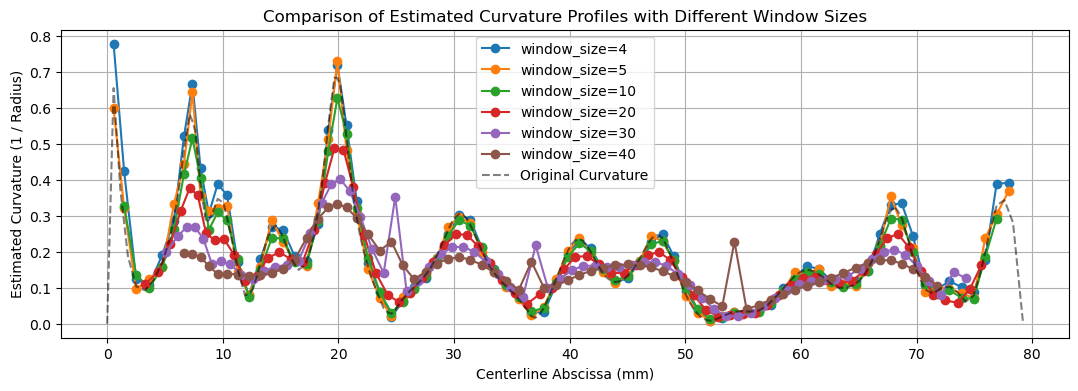

In [4]:
import matplotlib.pyplot as plt

window_sizes = [4, 5, 10, 20, 30, 40]
step_size = 3
radius_profiles = {}

# 先计算全局abscissas
diffs = np.diff(coords, axis=0)
segment_lengths = np.linalg.norm(diffs, axis=1)
abscissas = np.zeros(coords.shape[0])
abscissas[1:] = np.cumsum(segment_lengths)








for w in window_sizes:
    circles = sliding_window_fit_circles(coords, window_size=w, step_size=step_size)
    radii = [r for (_, _, r) in circles]

    # 窗口中心的弧长位置
    x_positions = [abscissas[i + w // 2] for i in range(0, len(coords) - w + 1, step_size)]
    radius_profiles[w] = (x_positions, radii)

# 画图
plt.figure(figsize=(13, 4))
for w, (x, radii) in radius_profiles.items():
    plt.plot(x, 1/np.array(radii), marker='o', label=f'window_size={w}')

# 原始曲率也用abscissas对齐
original_curvature = vtk_data_dict[file_names[0]]['point_data']['Curvature']
plt.plot(abscissas, original_curvature, label='Original Curvature', linestyle='--', color='black', alpha=0.5)

plt.xlabel('Centerline Abscissa (mm)')
plt.ylabel('Estimated Curvature (1 / Radius)')
plt.title('Comparison of Estimated Curvature Profiles with Different Window Sizes')
plt.legend()
plt.grid()
plt.show()




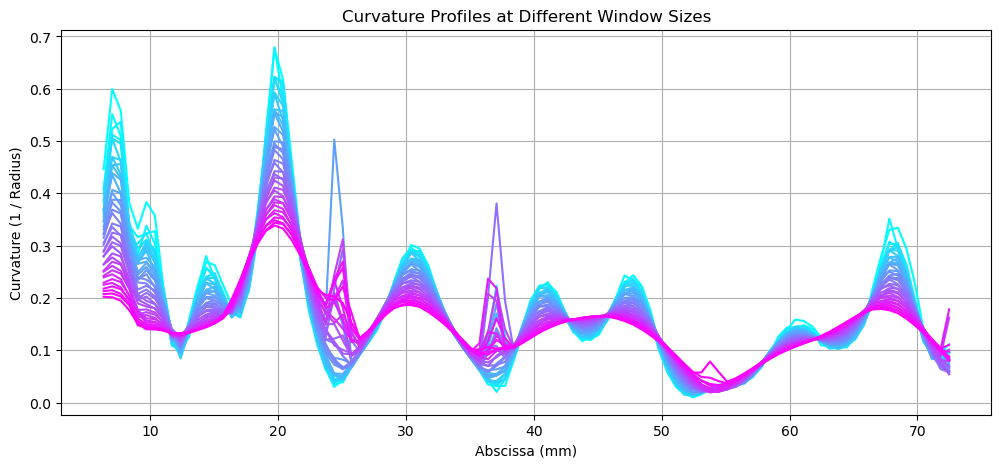

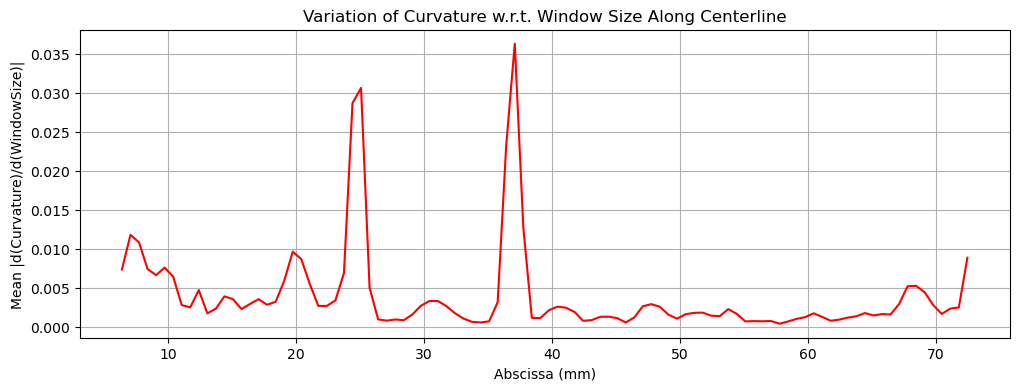

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# window_sizes = [4, 5, 10, 15, 20, 30]
window_sizes = range(4,40)
step_size = 3
radius_profiles = {}

# ---- 1️⃣ 全局abscissas计算 ----
diffs = np.diff(coords, axis=0)
segment_lengths = np.linalg.norm(diffs, axis=1)
abscissas = np.zeros(coords.shape[0])
abscissas[1:] = np.cumsum(segment_lengths)

# ---- 2️⃣ 计算每个window_size下的曲率 ----
for w in window_sizes:
    circles = sliding_window_fit_circles(coords, window_size=w, step_size=step_size)
    radii = [r for (_, _, r) in circles]
    curvature = 1 / np.array(radii)
    x_positions = [abscissas[i + w // 2] for i in range(0, len(coords) - w + 1, step_size)]
    radius_profiles[w] = (np.array(x_positions), curvature)

# ✅ 取最大窗口确定可用abscissas范围
max_window = max(window_sizes)
base_x = radius_profiles[max_window][0]
shared_start = base_x[0]
shared_end = base_x[-1]

# ✅ 定义细分的公共对齐网格
num_interp_points = 100
aligned_abscissa_grid = np.linspace(shared_start, shared_end, num_interp_points)

# ✅ 插值到这个细分网格
all_curvature_interp = []
for w in window_sizes:
    x, curv = radius_profiles[w]
    f = interp1d(x, curv, kind='linear', bounds_error=False, fill_value="extrapolate")
    curv_interp = f(aligned_abscissa_grid)
    all_curvature_interp.append(curv_interp)

all_curvature_interp = np.vstack(all_curvature_interp)


# ---- 5️⃣ 可视化 3️⃣ - 曲率在abscissa和window_size上的变化 ----
plt.figure(figsize=(12, 5))

# 生成窗口大小的归一化权重
norm_ws = (np.array(window_sizes) - min(window_sizes)) / (max(window_sizes) - min(window_sizes))
colors = plt.cm.cool(norm_ws)

for i, w in enumerate(window_sizes):
    plt.plot(
        aligned_abscissa_grid, 
        all_curvature_interp[i], 
        color=colors[i], 
        label=f'window_size={w}'
    )

plt.xlabel('Abscissa (mm)')
plt.ylabel('Curvature (1 / Radius)')
plt.title('Curvature Profiles at Different Window Sizes')
# plt.legend()
plt.grid()
plt.show()

# ---- 6️⃣ 计算 4️⃣ - 曲率对window_size的变化率 ----
# 近似为沿window_size维度的数值导数
window_sizes_arr = np.array(window_sizes)
d_curvature_d_window = np.gradient(all_curvature_interp, window_sizes_arr, axis=0)

# 绝对值的平均变化率（也可以其他定义）
variation_metric = np.mean(np.abs(d_curvature_d_window), axis=0)  # shape = (num_positions,)

# ---- 7️⃣ 可视化 4️⃣ 结果 ----
plt.figure(figsize=(12, 4))
plt.plot(aligned_abscissa_grid, variation_metric, color='red')
plt.xlabel('Abscissa (mm)')
plt.ylabel('Mean |d(Curvature)/d(WindowSize)|')
plt.title('Variation of Curvature w.r.t. Window Size Along Centerline')
plt.grid()
plt.show()


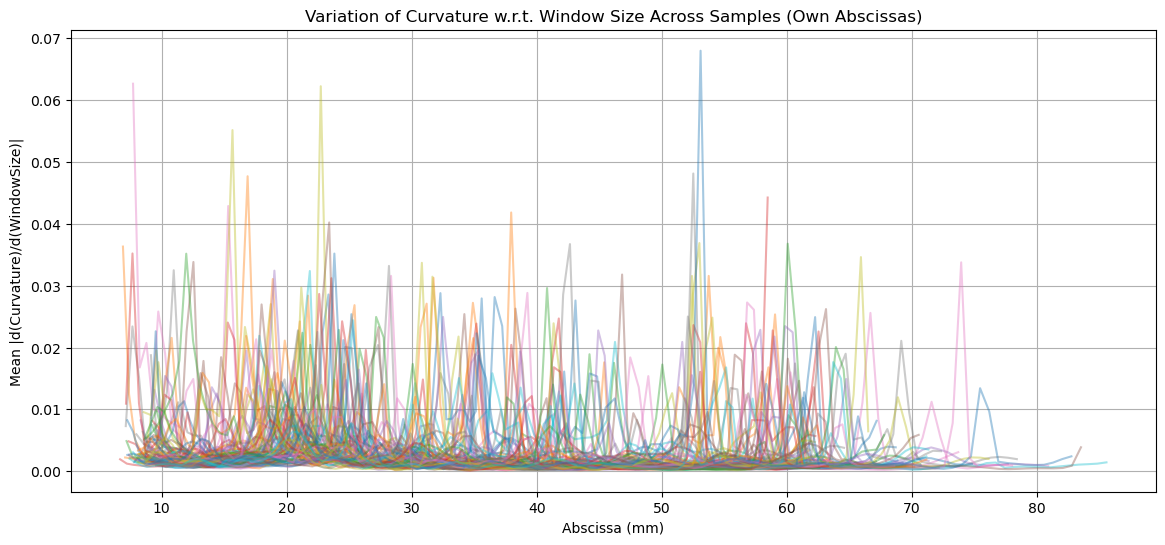

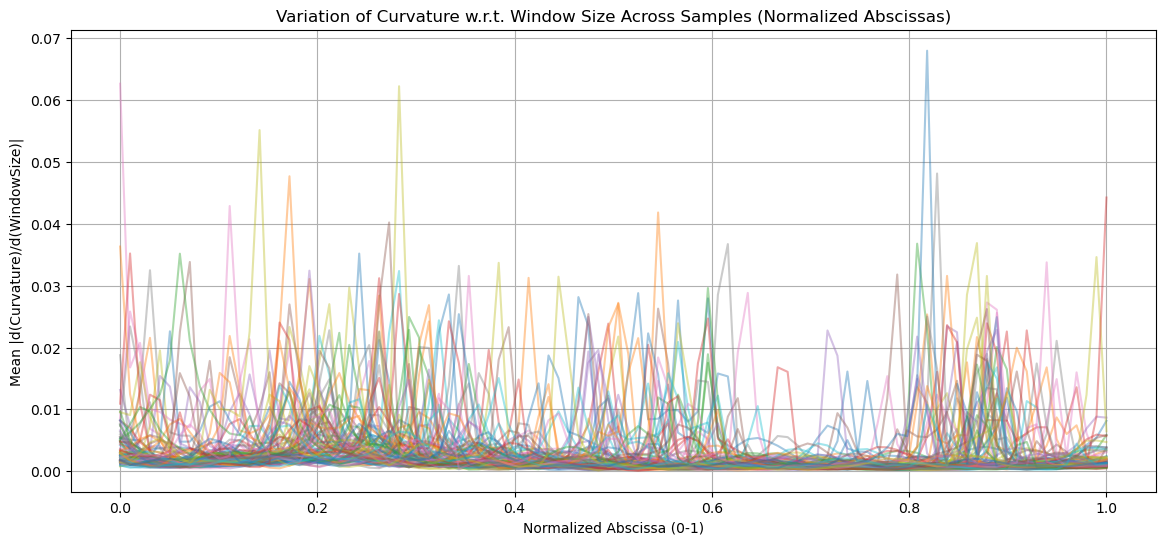

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

window_sizes = range(4, 60)
step_size = 2

all_samples_abscissas = []
all_samples_variation_curves = []
all_samples_normalized_abscissas = []   # 新增：标准化版本

for fname, content in vtk_data_dict.items():
    coords = content['coords']
    if coords.shape[0] < max(window_sizes):
        print(f"Skipping {fname}: too few points.")
        continue

    # 1️⃣ 计算该中心线的abscissas
    diffs = np.diff(coords, axis=0)
    segment_lengths = np.linalg.norm(diffs, axis=1)
    abscissas = np.zeros(coords.shape[0])
    abscissas[1:] = np.cumsum(segment_lengths)

    # 2️⃣ 对这个样本的多尺度曲率
    radius_profiles = {}
    for w in window_sizes:
        circles = sliding_window_fit_circles(coords, window_size=w, step_size=step_size)
        radii = [r for (_, _, r) in circles]
        curvature = 1 / np.array(radii)
        x_positions = [abscissas[i + w // 2] for i in range(0, len(coords) - w + 1, step_size)]
        radius_profiles[w] = (np.array(x_positions), curvature)

    # 3️⃣ 找所有尺度共享的abscissa范围
    starts = [v[0][0] for v in radius_profiles.values()]
    ends   = [v[0][-1] for v in radius_profiles.values()]
    shared_start = max(starts)
    shared_end   = min(ends)
    if shared_start >= shared_end:
        print(f"Skipping {fname}: no overlap across window sizes.")
        continue

    # 4️⃣ 定义该样本自己的对齐abscissa网格
    num_points = 100
    sample_abscissa_grid = np.linspace(shared_start, shared_end, num_points)

    # 5️⃣ 所有尺度结果插值到这个样本自己的网格
    all_curvature_interp = []
    for w in window_sizes:
        x, curv = radius_profiles[w]
        f = interp1d(x, curv, kind='linear', bounds_error=False, fill_value="extrapolate")
        curv_interp = f(sample_abscissa_grid)
        all_curvature_interp.append(curv_interp)
    all_curvature_interp = np.vstack(all_curvature_interp)  # (num_scales, num_points)

    # 6️⃣ 计算沿window_size维度的变化率
    window_sizes_arr = np.array(list(window_sizes))
    d_curvature_d_window = np.gradient(all_curvature_interp, window_sizes_arr, axis=0)
    variation_metric = np.mean(np.abs(d_curvature_d_window), axis=0)  # (num_points,)

    # 7️⃣ 记录这个样本的结果
    all_samples_abscissas.append(sample_abscissa_grid)
    all_samples_variation_curves.append(variation_metric)

    # 7.1️⃣ 生成并记录标准化abscissas
    normalized_abscissa = (sample_abscissa_grid - sample_abscissa_grid.min()) / (sample_abscissa_grid.max() - sample_abscissa_grid.min())
    all_samples_normalized_abscissas.append(normalized_abscissa)

    # print(f"{fname}: processed.")

# 8️⃣ 可视化所有样本（原始abscissas）
plt.figure(figsize=(14, 6))
for i in range(len(all_samples_variation_curves)):
    plt.plot(all_samples_abscissas[i], all_samples_variation_curves[i], alpha=0.4, label=f'Sample {i+1}')
plt.xlabel('Abscissa (mm)')
plt.ylabel('Mean |d(Curvature)/d(WindowSize)|')
plt.title('Variation of Curvature w.r.t. Window Size Across Samples (Own Abscissas)')
# plt.legend()
plt.grid()
plt.show()

# 9️⃣ 额外的图：标准化到0-1
plt.figure(figsize=(14, 6))
for i in range(len(all_samples_variation_curves)):
    plt.plot(all_samples_normalized_abscissas[i], all_samples_variation_curves[i], alpha=0.4, label=f'Sample {i+1}')
plt.xlabel('Normalized Abscissa (0-1)')
plt.ylabel('Mean |d(Curvature)/d(WindowSize)|')
plt.title('Variation of Curvature w.r.t. Window Size Across Samples (Normalized Abscissas)')
# plt.legend()
plt.grid()
plt.show()


Variation matrix shape: (91, 100)
Total values for distribution analysis: 9100


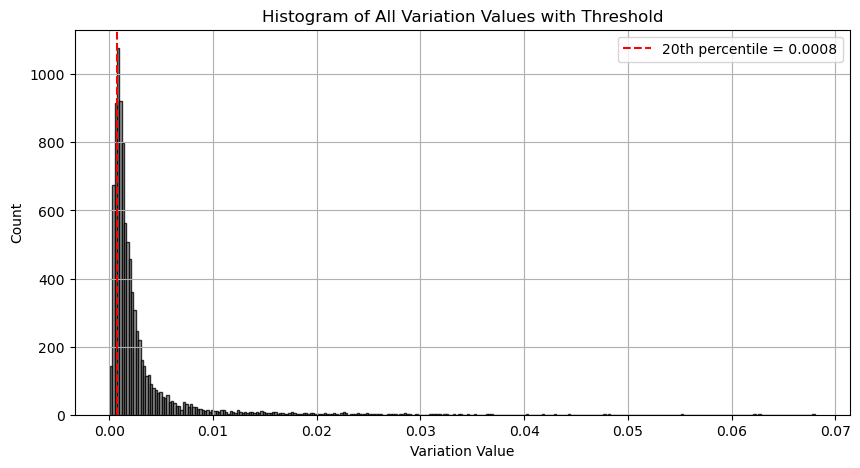

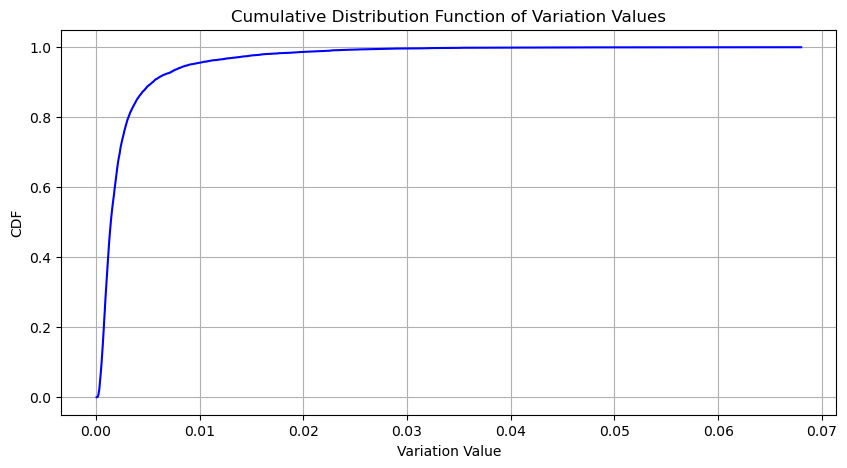

Chosen threshold for low variation: 0.0008
Binary mask shape: (91, 100)


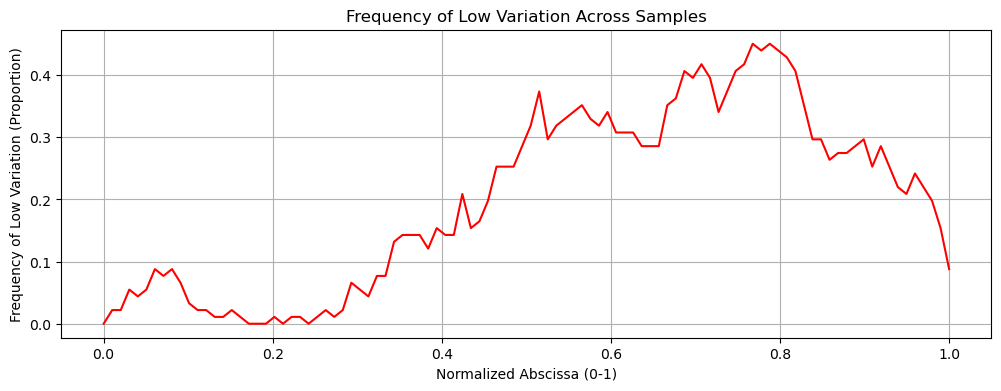

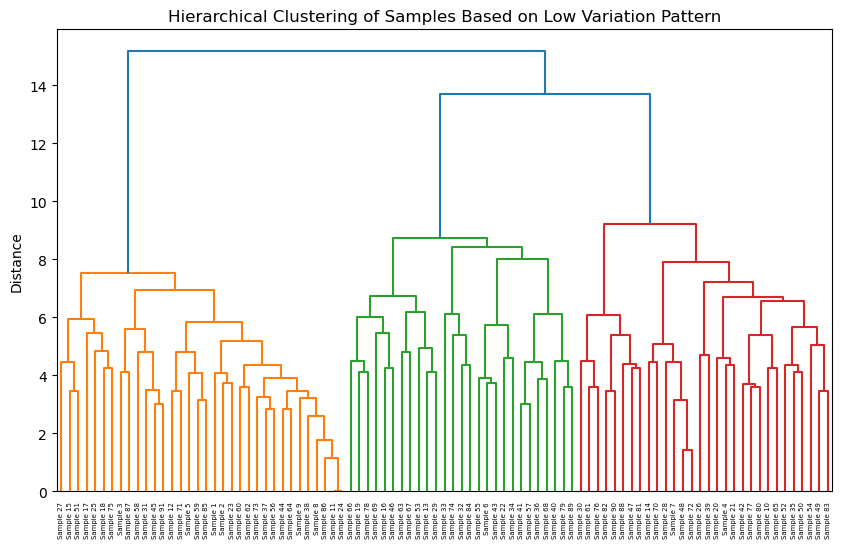

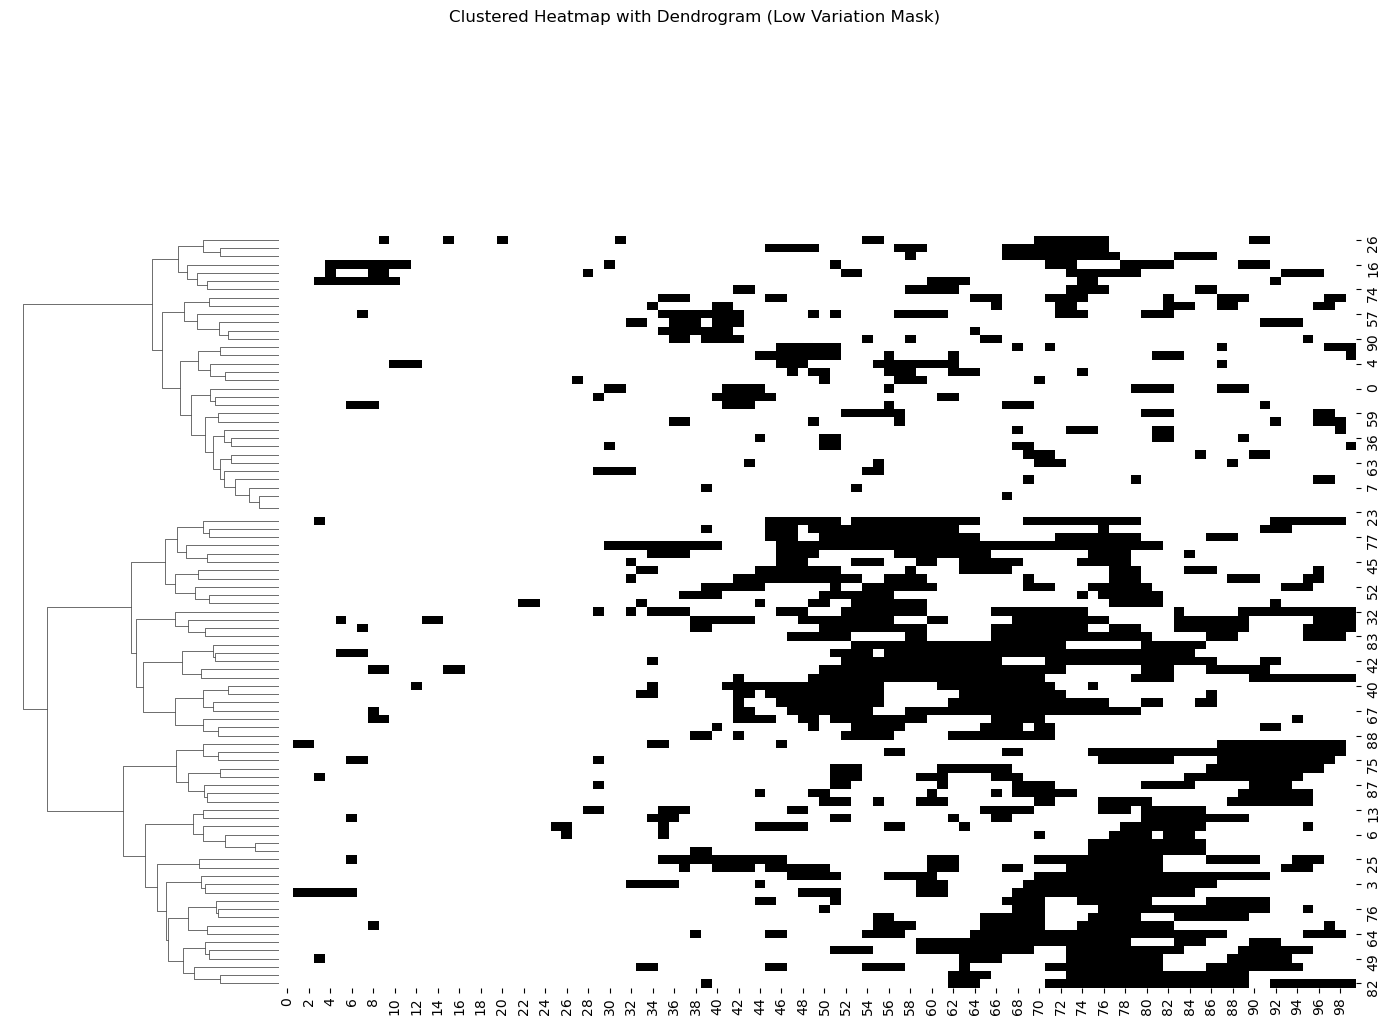

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram

global_percentile = 20

# ✅ 1️⃣ 把所有variation_curve堆成矩阵
variation_matrix = np.vstack(all_samples_variation_curves)  # shape (n_samples, num_points)
print("Variation matrix shape:", variation_matrix.shape)

all_values = variation_matrix.flatten()
print(f"Total values for distribution analysis: {len(all_values)}")

threshold_guess = np.percentile(all_values, global_percentile)
plt.figure(figsize=(10,5))
plt.hist(all_values, bins=300, color='gray', alpha=0.8, edgecolor='black')
plt.axvline(threshold_guess, color='red', linestyle='--', label=f'{global_percentile}th percentile = {threshold_guess:.4f}')
plt.xlabel('Variation Value')
plt.ylabel('Count')
plt.title('Histogram of All Variation Values with Threshold')
plt.legend()
plt.grid()
plt.show()

sorted_values = np.sort(all_values)
cdf = np.arange(1, len(sorted_values)+1) / len(sorted_values)

plt.figure(figsize=(10,5))
plt.plot(sorted_values, cdf, color='blue')
plt.xlabel('Variation Value')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function of Variation Values')
plt.grid()
plt.show()


# ✅ 2️⃣ 设阈值（全局分位数，比如25%分位数）
global_threshold = np.percentile(variation_matrix, global_percentile)
print(f"Chosen threshold for low variation: {global_threshold:.4f}")

# ✅ 3️⃣ 生成二值mask
binary_mask = (variation_matrix < global_threshold).astype(int)  # 低于阈值=1，高=0
print("Binary mask shape:", binary_mask.shape)

# ✅ 4️⃣ 画所有样本的mask Heatmap
# plt.figure(figsize=(14, 6))
# sns.heatmap(binary_mask, cmap='Greys', cbar=True)
# plt.xlabel('Normalized Abscissa Index (0-100)')
# plt.ylabel('Sample Index')
# plt.title('Heatmap of Low Variation Regions (1=Low Variation)')
# plt.show()

# ✅ 5️⃣ 统计各位置出现低变化率的频率
position_frequency = binary_mask.mean(axis=0)  # 每个abscissa位置有多少比例是低变化率

plt.figure(figsize=(12, 4))
plt.plot(np.linspace(0, 1, binary_mask.shape[1]), position_frequency, color='red')
plt.xlabel('Normalized Abscissa (0-1)')
plt.ylabel('Frequency of Low Variation (Proportion)')
plt.title('Frequency of Low Variation Across Samples')
plt.grid()
plt.show()

# ✅ 6️⃣ 对样本的二值模式做层次聚类
plt.figure(figsize=(10, 6))
linked = linkage(binary_mask, method='ward')
# linked = linkage(binary_mask, method='average', metric='hamming')
dendrogram(linked, labels=[f'Sample {i+1}' for i in range(binary_mask.shape[0])])
plt.title('Hierarchical Clustering of Samples Based on Low Variation Pattern')
plt.ylabel('Distance')
plt.show()


# # ✅ 重新用层次聚类结果排序样本
# from scipy.cluster.hierarchy import leaves_list

# # 获取聚类树的叶子顺序
# sorted_indices = leaves_list(linked)
# print("Sorted sample indices by clustering:", sorted_indices)

# # 用这个顺序重排binary_mask
# sorted_binary_mask = binary_mask[sorted_indices, :]

# # ✅ 画新的heatmap
# plt.figure(figsize=(14, 6))
# sns.heatmap(sorted_binary_mask, cmap='Greys', cbar=True)
# plt.xlabel('Normalized Abscissa Index (0-100)')
# plt.ylabel('Sample Index (Clustered Order)')
# plt.title('Heatmap of Low Variation Regions (Samples Sorted by Clustering)')
# plt.show()

import seaborn as sns

sns.clustermap(
    binary_mask,
    method='ward',
    metric='euclidean',
    cmap='Greys',
    figsize=(14, 10),
    # cbar_pos=(0.02, 0.8, 0.02, 0.18),
    col_cluster=False,  # ✅ 禁止列方向聚类
    cbar_pos=None
)

plt.suptitle('Clustered Heatmap with Dendrogram (Low Variation Mask)', y=1.02)
plt.show()

from scipy.cluster.hierarchy import fcluster

# 假设你已经有 linkage 结果
# linked = linkage(binary_mask, method='ward', metric='euclidean')

# 设定分群数
num_clusters = 3
cluster_labels = fcluster(linked, num_clusters, criterion='maxclust')

# 文件名列表，和binary_mask的行顺序对应
all_sample_names = list(vtk_data_dict.keys())

# 写回到字典的 cell_data 里
for fname, label in zip(all_sample_names, cluster_labels):
    vtk_data_dict[fname]['cell_data']['ClusterLabel'] = int(label)

from scipy.interpolate import interp1d

for fname, mask_row, sample_abscissa_grid in zip(all_sample_names, binary_mask, all_samples_abscissas):
    coords = vtk_data_dict[fname]['coords']
    N = coords.shape[0]

    # 中心线的原始弧长
    diffs = np.diff(coords, axis=0)
    segment_lengths = np.linalg.norm(diffs, axis=1)
    abscissas_full = np.zeros(N)
    abscissas_full[1:] = np.cumsum(segment_lengths)

    # 在截断区间做插值
    f_interp = interp1d(
        sample_abscissa_grid,
        mask_row,
        kind='linear',
        bounds_error=False,
        fill_value=0
    )

    mask_interp_full = f_interp(abscissas_full)

    # 可选：把插值后的值阈值化成严格的0/1
    binary_mask_full = (mask_interp_full >= 0.5).astype(int)

    # 保存到 point_data
    vtk_data_dict[fname]['point_data']['LowVariationMask'] = binary_mask_full.tolist()


In [8]:
import vtk
from vtk.util import numpy_support
import os

def save_vtk_polyline_with_data(coords, point_data, cell_data, out_path):
    """
    Save a single centerline with point_data and cell_data to .vtk file.
    """

    N = coords.shape[0]

    # 1️⃣ 创建 vtkPoints
    vtk_points = vtk.vtkPoints()
    for i in range(N):
        vtk_points.InsertNextPoint(coords[i])

    # 2️⃣ 创建 vtkPolyLine
    polyLine = vtk.vtkPolyLine()
    polyLine.GetPointIds().SetNumberOfIds(N)
    for i in range(N):
        polyLine.GetPointIds().SetId(i, i)

    # 3️⃣ 创建 vtkCellArray
    cells = vtk.vtkCellArray()
    cells.InsertNextCell(polyLine)

    # 4️⃣ 创建 vtkPolyData
    polyData = vtk.vtkPolyData()
    polyData.SetPoints(vtk_points)
    polyData.SetLines(cells)

    # 5️⃣ 添加 PointData
    for name, array in point_data.items():
        np_array = np.array(array)
        vtk_array = numpy_support.numpy_to_vtk(np_array, deep=True)
        vtk_array.SetName(name)
        polyData.GetPointData().AddArray(vtk_array)

    # 6️⃣ 添加 CellData (only 1 cell)
    for name, val in cell_data.items():
        vtk_array = numpy_support.numpy_to_vtk(np.array([val]), deep=True)
        vtk_array.SetName(name)
        polyData.GetCellData().AddArray(vtk_array)

    # 7️⃣ 写文件
    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(out_path)
    writer.SetInputData(polyData)
    writer.Write()



output_dir = 'vtk_with_lowvariation'  # 你想存的文件夹
os.makedirs(output_dir, exist_ok=True)

for fname, content in vtk_data_dict.items():
    coords = content['coords']
    coords_shifted = coords - coords[0]
    point_data = content['point_data']
    cell_data = content['cell_data']

    out_fname = os.path.join(output_dir, fname)
    # save_vtk_polyline_with_data(coords, point_data, cell_data, out_fname)
    save_vtk_polyline_with_data(coords_shifted, point_data, cell_data, out_fname)

    print(f"Saved: {out_fname}  |  ClusterLabel: {cell_data.get('ClusterLabel')}")



Saved: vtk_with_lowvariation\BG0001_L.vtk  |  ClusterLabel: 1
Saved: vtk_with_lowvariation\BG0001_R.vtk  |  ClusterLabel: 1
Saved: vtk_with_lowvariation\BG0003_L.vtk  |  ClusterLabel: 1
Saved: vtk_with_lowvariation\BG0003_R.vtk  |  ClusterLabel: 3
Saved: vtk_with_lowvariation\BG0004_L.vtk  |  ClusterLabel: 1
Saved: vtk_with_lowvariation\BG0004_R.vtk  |  ClusterLabel: 2
Saved: vtk_with_lowvariation\BG0006_L.vtk  |  ClusterLabel: 3
Saved: vtk_with_lowvariation\BG0006_R.vtk  |  ClusterLabel: 1
Saved: vtk_with_lowvariation\BG0007_L.vtk  |  ClusterLabel: 1
Saved: vtk_with_lowvariation\BG0007_R.vtk  |  ClusterLabel: 3
Saved: vtk_with_lowvariation\BG0008_L.vtk  |  ClusterLabel: 1
Saved: vtk_with_lowvariation\BG0008_R.vtk  |  ClusterLabel: 1
Saved: vtk_with_lowvariation\BG0009_L.vtk  |  ClusterLabel: 2
Saved: vtk_with_lowvariation\BG0009_R.vtk  |  ClusterLabel: 3
Saved: vtk_with_lowvariation\BG0010_L.vtk  |  ClusterLabel: 1
Saved: vtk_with_lowvariation\BG0010_R.vtk  |  ClusterLabel: 2
Saved: v

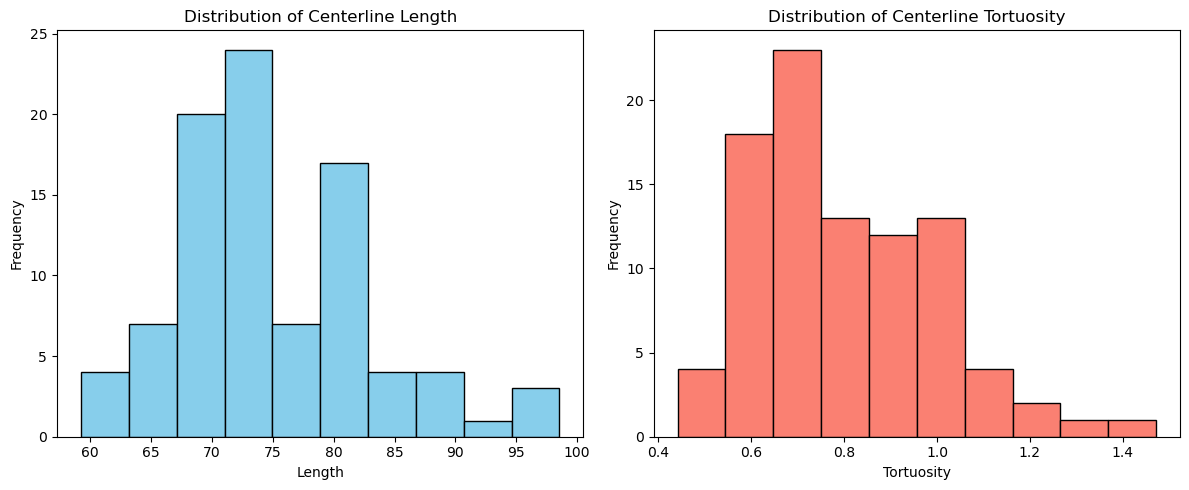

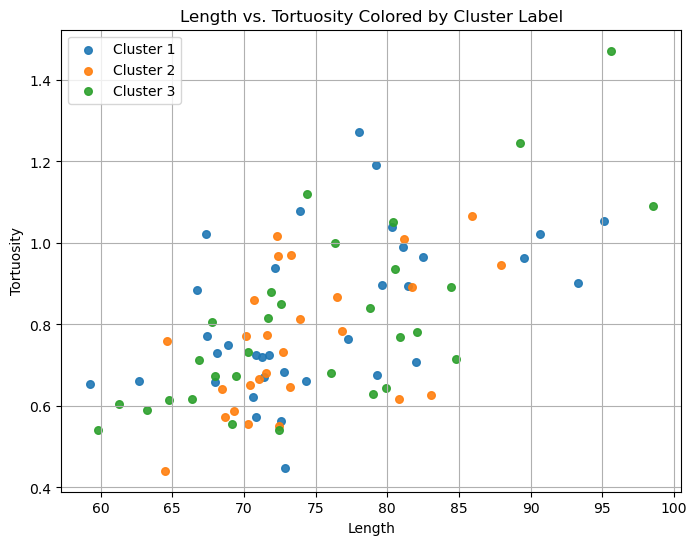

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# 收集所有 Length、Tortuosity、ClusterLabel
all_lengths = []
all_torts = []
all_labels = []

for content in vtk_data_dict.values():
    cell_data = content['cell_data']
    if 'Length' in cell_data and 'Tortuosity' in cell_data and 'ClusterLabel' in cell_data:
        all_lengths.append(cell_data['Length'])
        all_torts.append(cell_data['Tortuosity'])
        all_labels.append(cell_data['ClusterLabel'])

all_lengths = np.array(all_lengths)
all_torts = np.array(all_torts)
all_labels = np.array(all_labels)

# ✅ 画直方图（保留原来的）
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(all_lengths, bins=10, color='skyblue', edgecolor='black')
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.title("Distribution of Centerline Length")

plt.subplot(1, 2, 2)
plt.hist(all_torts, bins=10, color='salmon', edgecolor='black')
plt.xlabel("Tortuosity")
plt.ylabel("Frequency")
plt.title("Distribution of Centerline Tortuosity")

plt.tight_layout()
plt.show()

# ✅ 新增：散点图按label着色
plt.figure(figsize=(8, 6))
for label in np.unique(all_labels):
    mask = all_labels == label
    plt.scatter(all_lengths[mask], all_torts[mask], label=f'Cluster {label}', alpha=0.9, s=30)

plt.xlabel("Length")
plt.ylabel("Tortuosity")
plt.title("Length vs. Tortuosity Colored by Cluster Label")
plt.legend()
plt.grid()
plt.show()


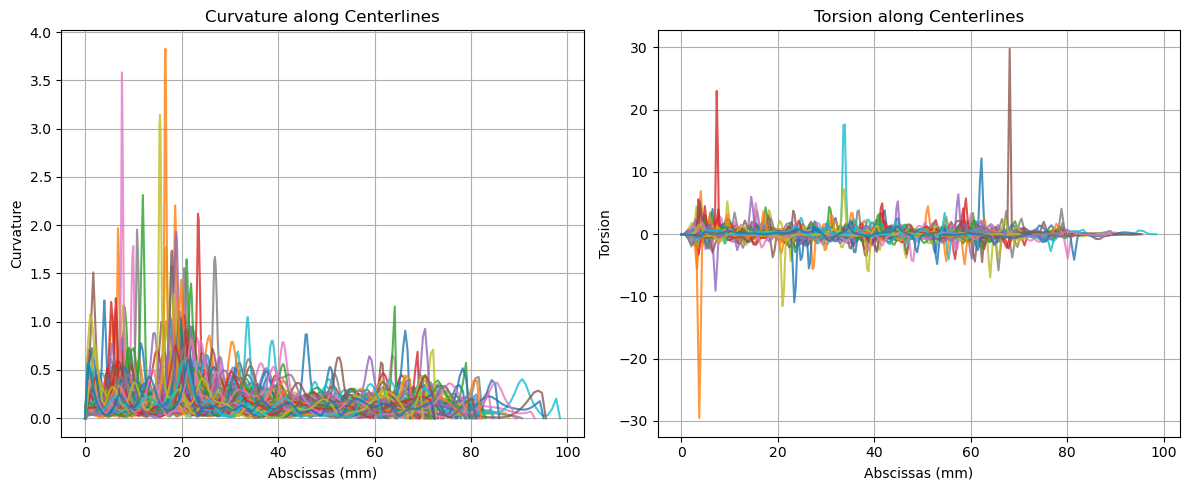

In [10]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# curvature subplot
plt.subplot(1, 2, 1)
for fname, content in vtk_data_dict.items():
    coords = content['coords']
    pdata = content['point_data']
    if 'Curvature' in pdata:
        diffs = np.linalg.norm(np.diff(coords, axis=0), axis=1)
        arc_length = np.concatenate([[0], np.cumsum(diffs)])
        plt.plot(arc_length, pdata['Curvature'], label=fname, alpha=0.8)
plt.title("Curvature along Centerlines")
plt.xlabel("Abscissas (mm)")
plt.ylabel("Curvature")
plt.grid(True)

# torsion subplot
plt.subplot(1, 2, 2)
for fname, content in vtk_data_dict.items():
    coords = content['coords']
    pdata = content['point_data']
    if 'Torsion' in pdata:
        diffs = np.linalg.norm(np.diff(coords, axis=0), axis=1)
        arc_length = np.concatenate([[0], np.cumsum(diffs)])
        plt.plot(arc_length, pdata['Torsion'], label=fname, alpha=0.8)
plt.title("Torsion along Centerlines")
plt.xlabel("Abscissas (mm)")
plt.ylabel("Torsion")
plt.grid(True)

plt.tight_layout()
plt.show()


In [11]:
from io import StringIO
import sys
import re
import csv

class OutputCatcher:
    def __init__(self):
        self._stdout = sys.stdout
        self.buffer = StringIO()

    def __enter__(self):
        sys.stdout = self.buffer
        return self

    def __exit__(self, *args):
        sys.stdout = self._stdout

    def get(self):
        return self.buffer.getvalue()

def parse_alignment_log(log_text):
    pattern_iter = re.compile(r"(updating step: r=|Iteration )(\d+)")
    pattern_residual = re.compile(r"Residual(?: Change)?: ([\d\.]+)")
    pattern_energy = re.compile(r"Residual Energy: ([\d\.]+)")

    results = {}
    current_iter = None

    for line in log_text.splitlines():
        iter_match = pattern_iter.search(line)
        if iter_match:
            current_iter = int(iter_match.group(2))
            if current_iter not in results:
                results[current_iter] = {'iter': current_iter}

        res_match = pattern_residual.search(line)
        if res_match and current_iter is not None:
            results[current_iter]['residual'] = float(res_match.group(1))

        ene_match = pattern_energy.search(line)
        if ene_match and current_iter is not None:
            results[current_iter]['energy'] = float(ene_match.group(1))

    # 转成列表并排序
    return [results[k] for k in sorted(results)]


def write_log_to_csv(results, filename):
    with open(filename, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["iter", "residual", "energy"])
        writer.writeheader()
        writer.writerows(results)
    print(f"[log] Wrote {len(results)} rows to {filename}")


[log] Wrote 20 rows to ./alignment_plain.csv
[log] Wrote 20 rows to ./alignment_weighted.csv


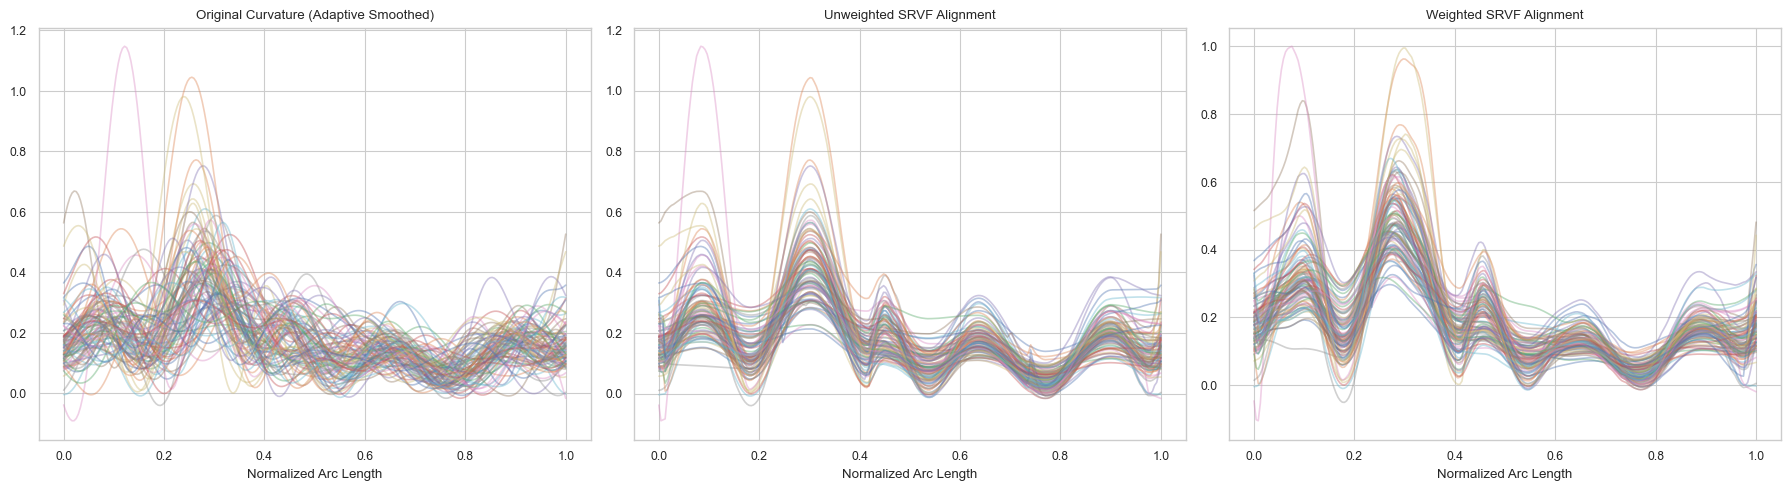

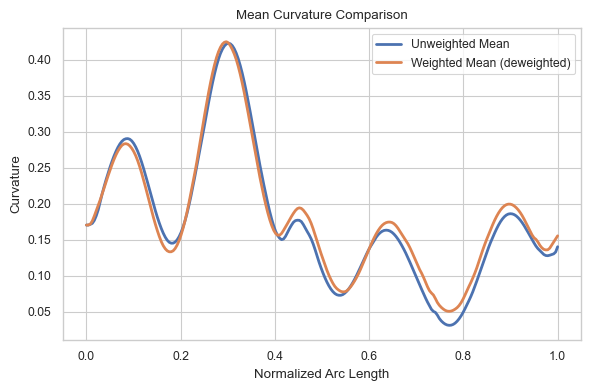

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft
from scipy.signal import find_peaks
from fdasrsf.utility_functions import resamplefunction
from fdasrsf.time_warping import fdawarp
import seaborn as sns

sns.set(style="whitegrid", context="paper", font_scale=1)
# 参数
# # target_len = 200
# target_len = 500  # 目标长度
t_resample = np.linspace(0, 1, TARGET_N )
alpha_s = 0.75

# Fourier 平滑函数
def fourier_lowpass(signal, keep_ratio):
    N = len(signal)
    fhat = fft(signal)
    keep = int(N * keep_ratio)
    fhat[keep:-keep] = 0
    return np.real(ifft(fhat))

# 自适应平滑函数：使平滑后曲线具有约 5 个峰
def adaptive_fourier_smoothing(signal, peak_target=5, tol=1, max_iter=50):
    ratios = np.linspace(0.01, 0.2, 100)
    for r in ratios:
        smoothed = fourier_lowpass(signal, keep_ratio=r)
        peaks, _ = find_peaks(smoothed,
                                prominence=(np.max(smoothed) - np.min(smoothed)) * 0.08,
                                distance=TARGET_N  // 10  # 避免过密峰值
                            )
        if abs(len(peaks) - peak_target) <= tol:
            return smoothed
    return fourier_lowpass(signal, keep_ratio=0.03)

# 结构权重函数（使用自适应傅立叶平滑）
def composite_weight(curves, alpha_s=0.75):
    """
    使用 adaptive Fourier smoothing 后的结构强度生成逐点加权权重。
    - curves: ndarray of shape [T, N]
    - alpha_s: 放大系数（越大越强调曲率突变区域）
    
    返回:
        weights: ndarray of shape [T, N]
    """
    T, N = curves.shape

    # Step 1: 对每条曲线使用 adaptive smoothing
    smoothed_curves = np.stack([
        adaptive_fourier_smoothing(curves[:, i], peak_target=5, tol=1)
        for i in range(N)
    ], axis=1)

    # Step 2: 局部结构强度（曲率绝对值）
    mag = np.abs(smoothed_curves)

    # Step 3: 一致性系数（强调 across-curves 一致的区域）
    consistency = 1.0 / (np.std(smoothed_curves, axis=1) + 1e-5)
    consistency = (consistency - consistency.min()) / (consistency.max() - consistency.min() + 1e-8)
    consistency = consistency[:, None]  # shape [T, 1]

    # Step 4: 综合权重计算
    weights = (1 + alpha_s * mag) * (0.5 + 0.5 * consistency)

    # Step 5: 全局归一化
    weights /= (weights.mean() + 1e-8)

    return weights  # shape [T, N]


# 主流程
names = list(vtk_data_dict.keys())
resampled_curves = []

for name in names:
    curvature = vtk_data_dict[name]["point_data"]["Curvature"]
    coords = vtk_data_dict[name]["coords"]

    # 不再重新插值，只保留 smoothing（输入已经是500点）
    curvature = adaptive_fourier_smoothing(curvature, peak_target=5, tol=1)
    resampled_curves.append(curvature)


f = np.stack(resampled_curves).T
time = t_resample

# # 不加权对齐
with OutputCatcher() as capture_plain:
    obj_plain = fdawarp(f.copy(), time)
    obj_plain.srsf_align(parallel=True, MaxItr=20, verbose=True)

plain_log = capture_plain.get()
plain_results = parse_alignment_log(plain_log)
write_log_to_csv(plain_results, "./alignment_plain.csv")

# 加权对齐
W = composite_weight(f, alpha_s=alpha_s)
obj_weighted = fdawarp(f.copy(), time)
obj_weighted.custom_weights = W.mean(axis=0)  # 向自定义方法传权重
alpha_init = 0.05
# momentum_beta = 0.9
momentum_beta1= 0.9
momentum_beta2 = 0.999

with OutputCatcher() as capture_weighted:
    obj_weighted.srsf_align_weighted(
        pointwise_weights=W,
        MaxItr=20,
        parallel=True,
        alpha=alpha_init,
        use_momentum=True,
        beta1=momentum_beta1,
        beta2=momentum_beta2
    )

weighted_log = capture_weighted.get()
weighted_results = parse_alignment_log(weighted_log)
write_log_to_csv(weighted_results, "./alignment_weighted.csv")


# 恢复加权后数据
f_weighted_unwrapped = obj_weighted.fn / W
# f_weighted_unwrapped = obj_weighted.fn

# 可视化
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
for i in range(f.shape[1]):
    plt.plot(time, f[:, i], alpha=0.4)
plt.title("Original Curvature (Adaptive Smoothed)")
plt.xlabel("Normalized Arc Length")
plt.grid(True)

plt.subplot(1, 3, 2)
for i in range(f.shape[1]):
    plt.plot(time, obj_plain.fn[:, i], alpha=0.4)
plt.title("Unweighted SRVF Alignment")
plt.xlabel("Normalized Arc Length")
plt.grid(True)

plt.subplot(1, 3, 3)
for i in range(f.shape[1]):
    plt.plot(time, f_weighted_unwrapped[:, i], alpha=0.4)
plt.title("Weighted SRVF Alignment")
plt.xlabel("Normalized Arc Length")
plt.grid(True)

plt.tight_layout()
plt.show()

# 平均曲率比较
plt.figure(figsize=(6, 4))
plt.plot(time, obj_plain.fmean, label='Unweighted Mean', lw=2)
plt.plot(time, obj_weighted.fmean, label='Weighted Mean (deweighted)', lw=2)
plt.xlabel("Normalized Arc Length")
plt.ylabel("Curvature")
plt.title("Mean Curvature Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

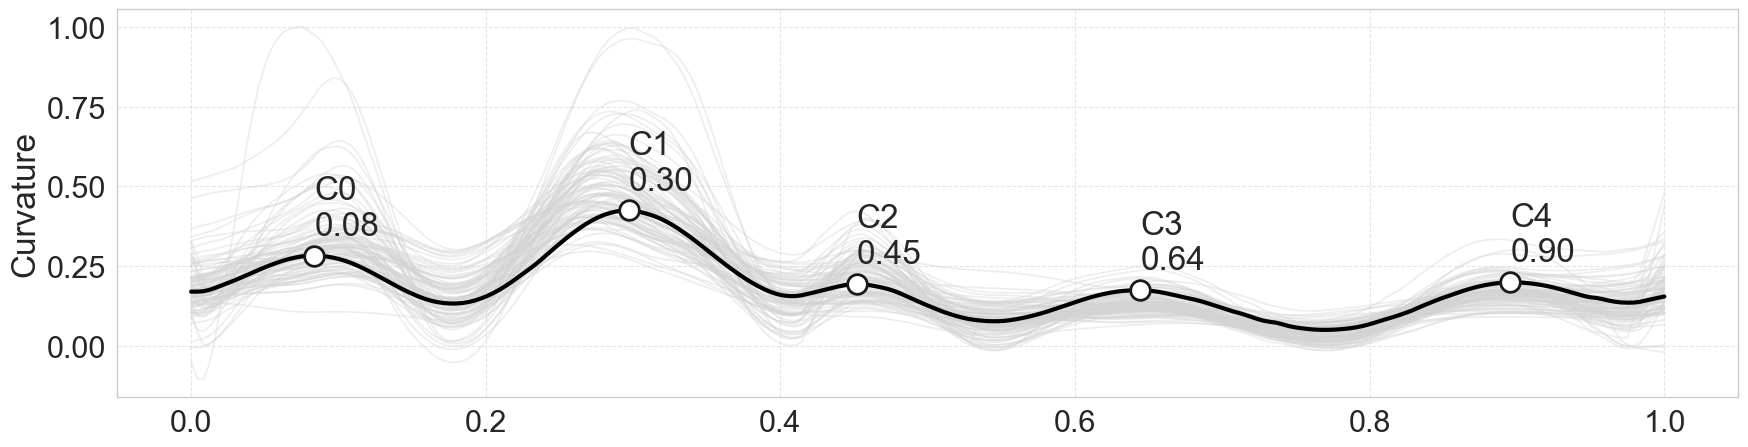

In [13]:
import seaborn as sns
from scipy.signal import find_peaks

sns.set(style="whitegrid", context="paper", font_scale=2.5)

# 计算去权重后的平均曲线
# mean_curve = obj_weighted.fmean / W.mean(axis=1)
mean_curve = obj_weighted.fmean

# 寻找峰值点
peaks, _ = find_peaks(
    mean_curve,
    prominence=(np.max(mean_curve) - np.min(mean_curve)) * 0.08,  # 自适应prominence
    distance=TARGET_N // 10                                     # 控制峰值间距（25点）
)

# 将峰值按 x 坐标排序（从左到右）
sorted_peaks = peaks[np.argsort(time[peaks])]

# 可视化
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(111)

# 所有对齐曲线
for i in range(f.shape[1]):
    ax.plot(time, f_weighted_unwrapped[:, i], alpha=0.4, color='lightgray')

# 平均曲线
ax.plot(time, mean_curve, label='Weighted Mean (deweighted)', lw=3, color='black')

# 标注峰值
ax.scatter(time[sorted_peaks], mean_curve[sorted_peaks],
           color='white', edgecolors='k', linewidths=2,
           s=200, zorder=10, label='Peaks')

# 添加标注文字 C0 ~ Cn 和对应高度
for i, idx in enumerate(sorted_peaks):
    peak_x = time[idx]
    peak_y = mean_curve[idx]
    ax.annotate(f"C{i}\n{peak_x:.2f}", xy=(peak_x, peak_y),
                xytext=(0, 10), textcoords='offset points',
                ha='left', va='bottom', fontsize=24,
                arrowprops=dict(arrowstyle='-', lw=1))

# 标签和网格
ax.set_ylabel("Curvature")
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.legend()
plt.show()


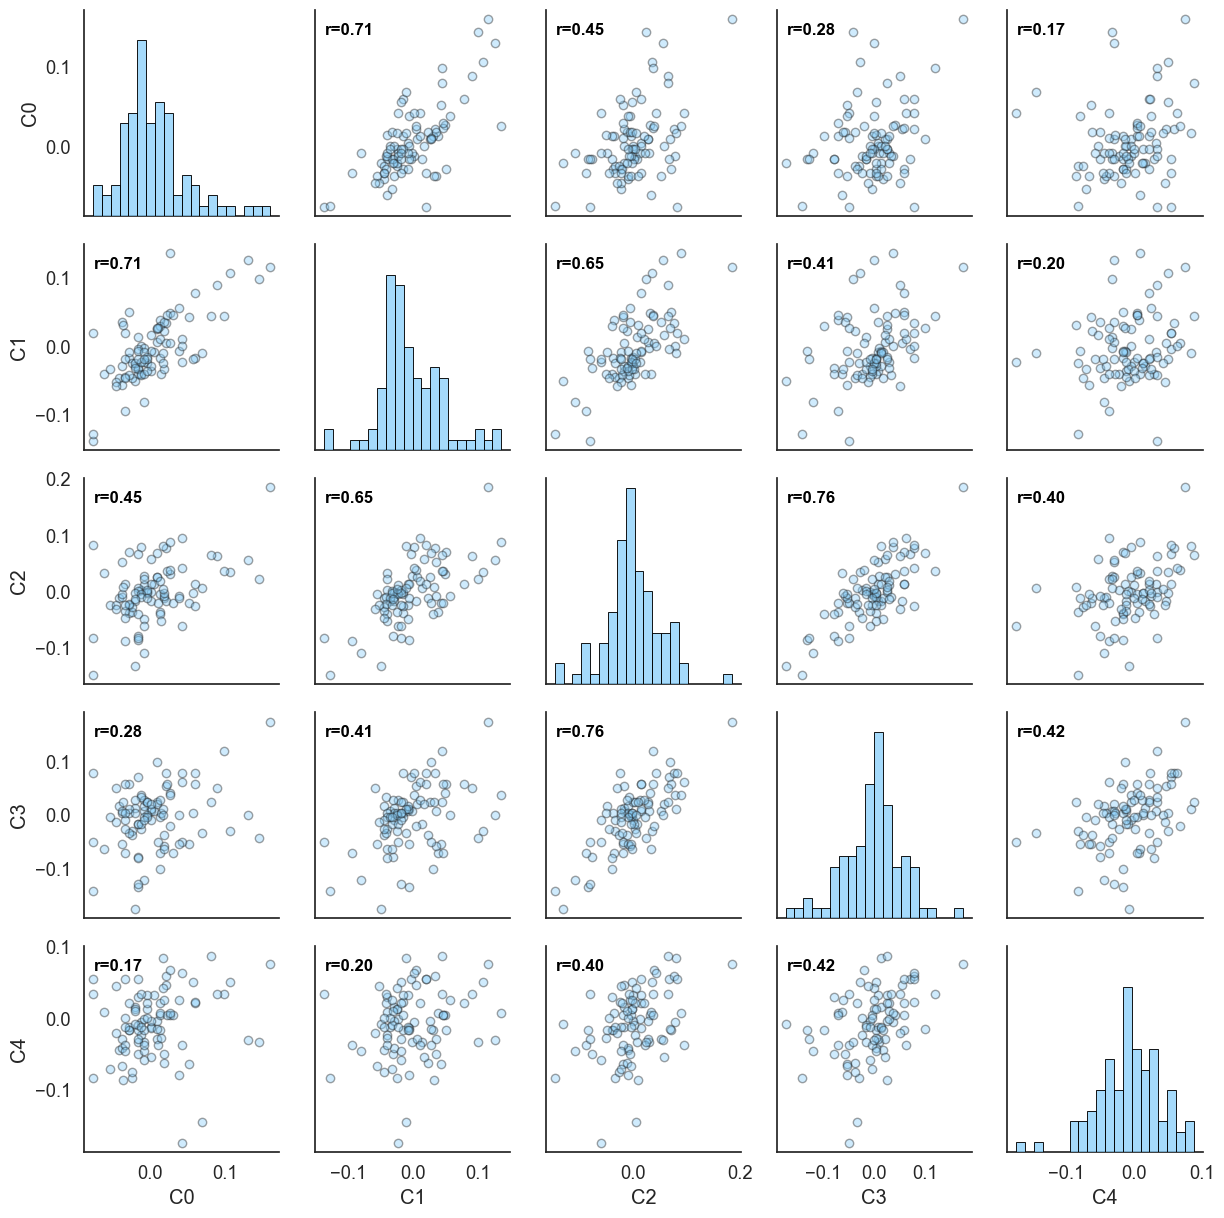

f_weighted_unwrapped shape: (240, 91)
Number of samples: 91
Number of peaks: 5

Extracted values at peaks:
         C0        C1        C2        C3        C4
0  0.348107  0.368473  0.187973  0.135741  0.167895
1  0.329083  0.425718  0.157629  0.138958  0.171128
2  0.247697  0.485599  0.142078  0.074450  0.127078
3  0.260706  0.502646  0.250596  0.124889  0.160977
4  0.290931  0.440110  0.136929  0.118496  0.176823


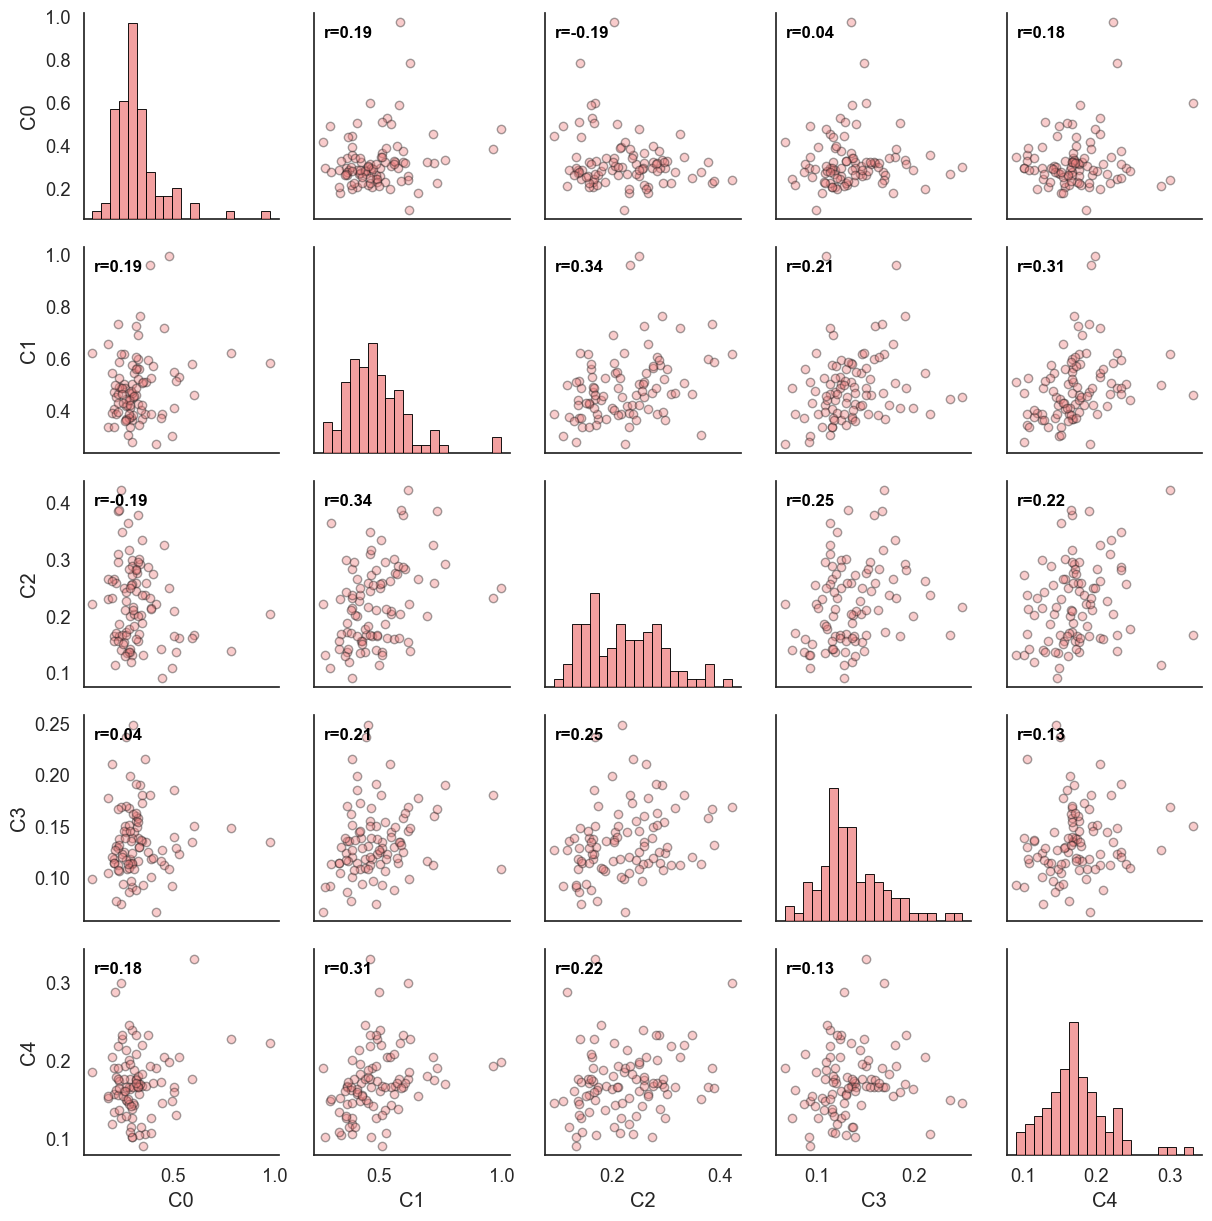

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

sns.set(style="white", context="notebook", font_scale=1.2)

# ------------------------------------------------------------
# === Part 1: Time Shifts at Peaks (Blue Theme) ===
# ------------------------------------------------------------

# 1️⃣ 计算所有样本在mean曲线的C0~Cn处的时间shift
gammas = obj_weighted.gam.T
peak_times = time[sorted_peaks]

n_samples = gammas.shape[0]
n_peaks = len(peak_times)
shifts = np.zeros((n_samples, n_peaks))

for i in range(n_samples):
    f_gamma = interp1d(time, gammas[i, :], kind='linear', bounds_error=False, fill_value="extrapolate")
    shifts[i, :] = f_gamma(peak_times) - peak_times

shift_df = pd.DataFrame(shifts, columns=[f'C{i}' for i in range(n_peaks)])

# 2️⃣ 统一颜色和绘图函数
blue_color = 'lightskyblue'

def diag_hist_blue(x, **kwargs):
    ax = plt.gca()
    sns.histplot(x, bins=20, color=blue_color, edgecolor='black', ax=ax)

def offdiag_scatter_with_r_blue(x, y, **kwargs):
    ax = plt.gca()
    ax.scatter(x, y, alpha=0.4, color=blue_color, edgecolor='k')
    r = np.corrcoef(x, y)[0, 1]
    ax.annotate(f"r={r:.2f}", xy=(0.05, 0.9), xycoords='axes fraction',
                ha='left', va='center', fontsize=12, fontweight='bold', color='black')

# 3️⃣ 画 PairGrid
g = sns.PairGrid(shift_df, corner=False)
g.map_diag(diag_hist_blue)
g.map_offdiag(offdiag_scatter_with_r_blue)

# plt.suptitle('Pairwise Relationships of Time Shifts at Peaks (Uniform Blue Theme)', y=1.02)
plt.show()

# ------------------------------------------------------------
# === Part 2: Curvature Values at Peaks (Red Theme) ===
# ------------------------------------------------------------

print(f"f_weighted_unwrapped shape: {f_weighted_unwrapped.shape}")
print(f"Number of samples: {f_weighted_unwrapped.shape[1]}")
print(f"Number of peaks: {len(peak_times)}")

# 1️⃣ 计算所有样本在 mean_curve 的 peak_times 处的曲率值
n_samples = f_weighted_unwrapped.shape[1]
values_at_peaks = np.zeros((n_samples, n_peaks))

for i in range(n_samples):
    f_interp = interp1d(time, f_weighted_unwrapped[:, i], kind='linear', bounds_error=False, fill_value="extrapolate")
    values_at_peaks[i, :] = f_interp(peak_times)

value_df = pd.DataFrame(values_at_peaks, columns=[f'C{i}' for i in range(n_peaks)])
print("\nExtracted values at peaks:")
print(value_df.head())

# 2️⃣ 统一颜色和绘图函数
red_color = 'lightcoral'

def diag_hist_red(x, **kwargs):
    ax = plt.gca()
    sns.histplot(x, bins=20, color=red_color, edgecolor='black', ax=ax)

def offdiag_scatter_with_r_red(x, y, **kwargs):
    ax = plt.gca()
    ax.scatter(x, y, alpha=0.4, color=red_color, edgecolor='k')
    r = np.corrcoef(x, y)[0, 1]
    ax.annotate(f"r={r:.2f}", xy=(0.05, 0.9), xycoords='axes fraction',
                ha='left', va='center', fontsize=12, fontweight='bold', color='black')

# 3️⃣ 画 PairGrid
g = sns.PairGrid(value_df, corner=False)
g.map_diag(diag_hist_red)
g.map_offdiag(offdiag_scatter_with_r_red)

# plt.suptitle('Pairwise Relationships of Curvature Values at Peaks (Uniform Red Theme)', y=1.02)
plt.show()


PC1: Variance = 0.5666, Cumulative = 0.5666
PC2: Variance = 0.2159, Cumulative = 0.7825
PC3: Variance = 0.1090, Cumulative = 0.8915


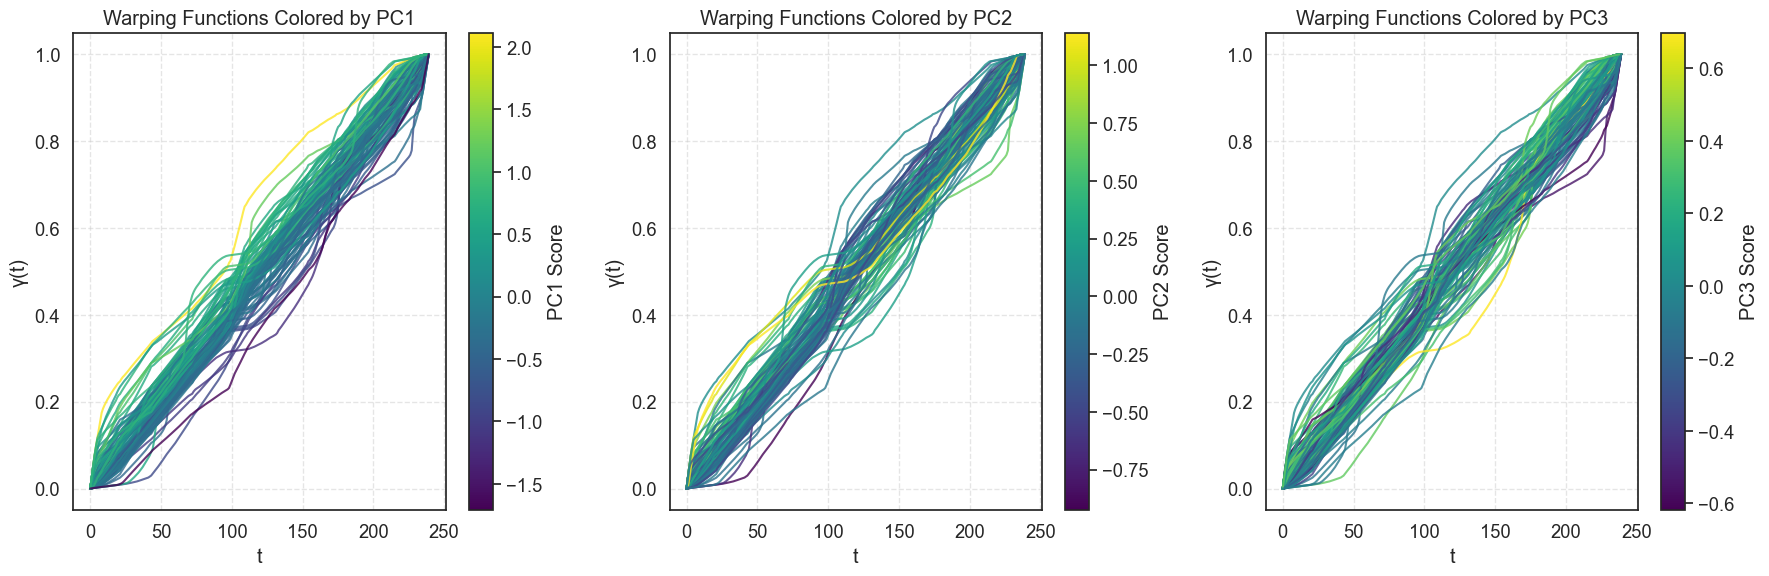

Labels (0–7 classes):
[3 0 4 1 7 6 0 5 0 4 2 2 4 5 2 4 4 4 1 1 0 7 4 5 3 3 7 1 0 0 5 3 2 4 6 0 5
 2 1 2 4 0 0 0 3 5 4 5 6 7 3 3 7 0 5 0 2 0 0 5 4 2 5 4 0 0 1 3 0 5 2 1 1 6
 7 5 5 2 0 6 1 1 7 0 7 0 5 6 0 7 0]


In [15]:
from sklearn.decomposition import PCA
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np

# PCA
pca = PCA(n_components=3)
X = obj_weighted.gam.T
X_pca = pca.fit_transform(X)

# 累计寄与率
explained = pca.explained_variance_ratio_
cumulative_explained = np.cumsum(explained)

# 输出
for i, (var, cum) in enumerate(zip(explained, cumulative_explained)):
    print(f"PC{i+1}: Variance = {var:.4f}, Cumulative = {cum:.4f}")


fig, axs = plt.subplots(1, 3, figsize=(18, 6))
pcs = ['PC1', 'PC2', 'PC3']
cmap = cm.viridis

for j in range(3):
    pc_values = X_pca[:, j]
    norm = Normalize(vmin=np.min(pc_values), vmax=np.max(pc_values))

    for i in range(X.shape[0]):
        axs[j].plot(obj_weighted.gam[:, i],
                    color=cmap(norm(pc_values[i])),
                    alpha=0.8)

    axs[j].set_title(f"Warping Functions Colored by {pcs[j]}")
    axs[j].set_xlabel("t")
    axs[j].set_ylabel("γ(t)")
    axs[j].grid(True, linestyle='--', alpha=0.5)

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axs[j])
    cbar.set_label(f"{pcs[j]} Score")

plt.tight_layout()
plt.show()


import numpy as np
from sklearn.decomposition import PCA

# 计算每个 PC 的均值
pc_means = X_pca.mean(axis=0)  # shape: (3,)

# 比较每个样本的每个 PC 是否大于均值
binary_flags = (X_pca > pc_means).astype(int)  # shape: (n_samples, 3)

# 将每行的三个 0/1 编码转为 0–7 的整数标签（PC1 为高位）
labels = binary_flags[:, 0] * 4 + binary_flags[:, 1] * 2 + binary_flags[:, 2]

# 输出 labels（长度等于样本数）
print("Labels (0–7 classes):")
print(labels)


In [16]:
# import os
# import numpy as np
# from scipy.signal import find_peaks
# from scipy.interpolate import PchipInterpolator
# import vtk
# from vtk.util import numpy_support

# def extract_peaks_and_zeros(signal):
#     peaks_pos, _ = find_peaks(signal, prominence=0.05)
#     peaks_neg, _ = find_peaks(-signal, prominence=0.05)
#     signs = np.sign(signal)
#     zeros = np.where(np.diff(signs) != 0)[0]
#     zeros = [i for i in zeros if abs(signal[i]) > 0.01 and abs(signal[i+1]) > 0.01]
#     return np.asarray(peaks_pos), np.asarray(peaks_neg), np.asarray(zeros)

# def create_binary_mask(length, indices):
#     arr = np.zeros(length, dtype=np.uint8)
#     arr[np.clip(indices, 0, length-1)] = 1
#     return arr

# def invert_gamma(gamma):
#     T = len(gamma)
#     x = np.linspace(0, 1, T)
#     return PchipInterpolator(gamma, x, extrapolate=True)

# def map_mask_back(indices, gamma, target_len, value=1):
#     T = len(gamma)
#     x = np.linspace(0, 1, T)
#     gamma_inv = invert_gamma(gamma)
#     mapped = gamma_inv(x[indices])
#     idx = np.clip(np.round(mapped * target_len).astype(int), 0, target_len - 1)
#     arr = np.zeros(target_len, dtype=np.uint8)
#     arr[idx] = value
#     return arr

# def write_vtk_with_annotations(input_path, output_path, annotations):
#     reader = vtk.vtkPolyDataReader()
#     reader.SetFileName(input_path)
#     reader.Update()
#     polydata = reader.GetOutput()
#     for name, array in annotations.items():
#         vtk_array = numpy_support.numpy_to_vtk(array, deep=True, array_type=vtk.VTK_UNSIGNED_CHAR)
#         vtk_array.SetName(name)
#         polydata.GetPointData().AddArray(vtk_array)
#     writer = vtk.vtkPolyDataWriter()
#     writer.SetFileName(output_path)
#     writer.SetInputData(polydata)
#     writer.Write()

# # ====== 参数 ======
# T = 200
# output_dir = os.path.join(base_dir, "with_curv_torsion_annotations")
# os.makedirs(output_dir, exist_ok=True)

# # ====== 注释源数据 ======
# mean_curv = results['Smoothed']['obj_weighted'].fmean / results['Smoothed']['W'].mean(axis=1)
# curv_peaks = find_peaks(mean_curv, prominence=0.05)[0]

# # torsion 加权版
# mean_torsion_s = results['Smoothed']['obj_weighted'].fmean / results['Smoothed']['W'].mean(axis=1)
# tp_s, tn_s, tz_s = extract_peaks_and_zeros(mean_torsion_s)

# # torsion 普通版
# mean_torsion_r = results['Raw']['obj_weighted'].fmean / results['Raw']['W'].mean(axis=1)
# tp_r, tn_r, tz_r = extract_peaks_and_zeros(mean_torsion_r)

# gammas_plain = results['Smoothed']['obj_plain'].gam
# gammas_weighted = results['Smoothed']['obj_weighted'].gam

# # ====== 遍历文件写入 ======
# for i, fname in enumerate(vtk_data_dict.keys()):
#     gamma_plain = gammas_plain[:, i]
#     gamma_weighted = gammas_weighted[:, i]
#     coords = vtk_data_dict[fname]["coords"]
#     n_points = len(coords)

#     annotations = {
#         # curvature peaks
#         "plain_curvature_peaks": map_mask_back(curv_peaks, gamma_plain, n_points),
#         "weighted_curvature_peaks": map_mask_back(curv_peaks, gamma_weighted, n_points),

#         # smoothed torsion
#         "plain_torsion_tp": map_mask_back(tp_s, gamma_plain, n_points, value=1),
#         "plain_torsion_tn": map_mask_back(tn_s, gamma_plain, n_points, value=2),
#         "plain_torsion_tz": map_mask_back(tz_s, gamma_plain, n_points, value=3),

#         "weighted_torsion_tp": map_mask_back(tp_s, gamma_weighted, n_points, value=1),
#         "weighted_torsion_tn": map_mask_back(tn_s, gamma_weighted, n_points, value=2),
#         "weighted_torsion_tz": map_mask_back(tz_s, gamma_weighted, n_points, value=3),

#         # raw torsion
#         "plain_torsion_tp_raw": map_mask_back(tp_r, gamma_plain, n_points, value=1),
#         "plain_torsion_tn_raw": map_mask_back(tn_r, gamma_plain, n_points, value=2),
#         "plain_torsion_tz_raw": map_mask_back(tz_r, gamma_plain, n_points, value=3),

#         "weighted_torsion_tp_raw": map_mask_back(tp_r, gamma_weighted, n_points, value=1),
#         "weighted_torsion_tn_raw": map_mask_back(tn_r, gamma_weighted, n_points, value=2),
#         "weighted_torsion_tz_raw": map_mask_back(tz_r, gamma_weighted, n_points, value=3)
#     }

#     input_path = os.path.join(base_dir, fname)
#     output_path = os.path.join(output_dir, fname)
#     write_vtk_with_annotations(input_path, output_path, annotations)

# print(f"✅ Done: annotations saved to {output_dir}")


C:\Users\cheno\AppData\Local\Temp\ipykernel_35020\10038063.py:13: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



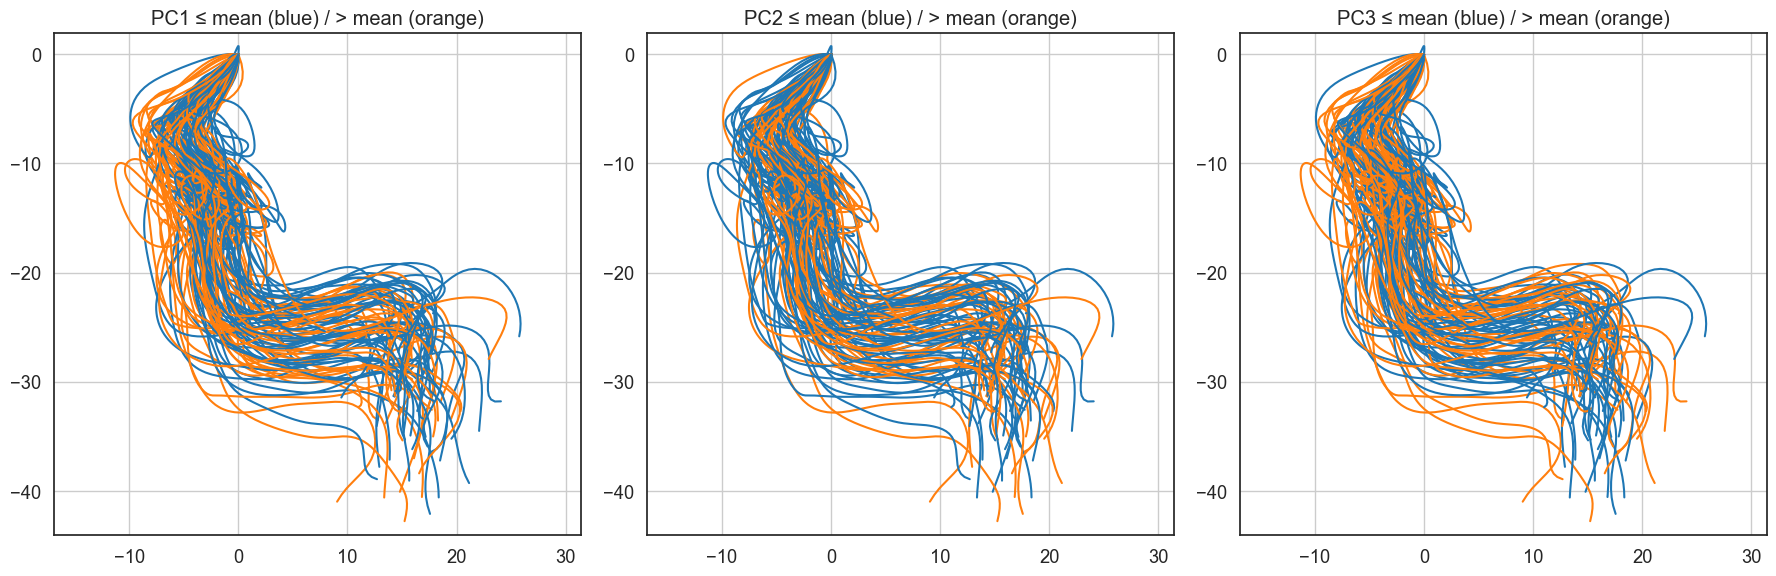

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# 假设你已有：
# - coords_array: list of (N, 3) arrays
# - labels: array of shape (n_samples,) with values in 0–7
# - X_pca: PCA投影后的 (n_samples, 3) 数据

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# 构造颜色映射（最多8类，取colormap前8个颜色）
cmap = cm.get_cmap('tab10', 8)
colors = [cmap(i) for i in range(8)]

# 图1：按 PC1 分
for i in range(len(coords_array)):
    pc1_group = (labels[i] & 4) >> 2  # 取第1位（高位）
    axs[0].plot(coords_array[i][:, 0], coords_array[i][:, 1],
                color=colors[pc1_group], linewidth=1.5)
axs[0].set_title("PC1 ≤ mean (blue) / > mean (orange)")
axs[0].axis("equal")
axs[0].grid(True)

# 图2：按 PC2 分
for i in range(len(coords_array)):
    pc2_group = (labels[i] & 2) >> 1  # 取第2位
    axs[1].plot(coords_array[i][:, 0], coords_array[i][:, 1],
                color=colors[pc2_group], linewidth=1.5)
axs[1].set_title("PC2 ≤ mean (blue) / > mean (orange)")
axs[1].axis("equal")
axs[1].grid(True)

# 图3：按 PC3 分
for i in range(len(coords_array)):
    pc3_group = (labels[i] & 1)  # 取第3位
    axs[2].plot(coords_array[i][:, 0], coords_array[i][:, 1],
                color=colors[pc3_group], linewidth=1.5)
axs[2].set_title("PC3 ≤ mean (blue) / > mean (orange)")
axs[2].axis("equal")
axs[2].grid(True)

plt.tight_layout()
plt.show()


In [18]:
import numpy as np 
import glob 
import vtk
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from AngioMorphPCA.preprocessing import parameterize_curve, calculate_3d_curve_abscissas,remove_high_freq_components, min_max_normalize, autocovariance_function
from AngioMorphPCA.io import Get_simple_vtk, makeVtkFile
from scipy.integrate import simps
from AngioMorphPCA.GenerateDiffHemeo import generate_diff_homeomorphism
from AngioMorphPCA.srvf_rep import compute_srvf_func, reconstruct_curve_from_srvf
from AngioMorphPCA.L2distance import calculate_l2_distance
from AngioMorphPCA.compute_geometry import compute_curvature_and_torsion,build_curve_from_curvatures
from tqdm import tqdm
import matplotlib.pyplot as plt
from geomstats.learning.frechet_mean import FrechetMean
import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    insert_zeros,
)
from geomstats.learning.pca import TangentPCA
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
from scipy.stats import linregress
from scipy.stats import pearsonr
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.signal import find_peaks
from matplotlib import cm
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.stats import norm
from AngioMorphPCA.make_figures import set_x_ticks_normalized
import fdasrsf as fs
from sklearn.svm import SVC
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import GridSearchCV, cross_val_score
from skimage import measure
import vtk
import pandas as pd

from scipy.ndimage import gaussian_filter
sns.set_context('notebook', font_scale=1.2)
from scipy.integrate import simps


def preprocess_open_curve(curve, target_k=100):
    """
    对3D开曲线进行标准化处理：
    - 起点对齐
    - 重采样为 target_k+1 个点（以便后续删去起点）
    - 缩放为单位弧长
    - 去除首点（避免 SRVMetric 奇异）

    返回：
    - processed_curve: 长度为1的统一曲线 (target_k, 3)，不含首点
    - original_length: 原始长度（用于逆缩放）
    """
    # 起点平移
    curve = curve - curve[0]

    # 原始参数化（基于弧长）
    diffs = np.diff(curve, axis=0)
    seg_lengths = np.linalg.norm(diffs, axis=1)
    cumlen = np.concatenate([[0], np.cumsum(seg_lengths)])
    t_orig = cumlen / cumlen[-1]
    original_length = cumlen[-1]

    # 重采样为 target_k+1 个点
    t_target = np.linspace(0, 1, target_k + 1)
    interp = interp1d(t_orig, curve, axis=0, kind='linear')
    resampled = interp(t_target)

    # 缩放为单位弧长
    resampled /= original_length

    # 删除首点（确保满足 DiscreteCurvesStartingAtOrigin 要求）
    processed_curve = resampled[1:]

    return processed_curve, original_length


tPCA_N_COMPONENTS = 16

k_sampling_points = TARGET_N # TARGET_N=240
# curve_cs = coords_array.copy()
curve_cs = []
for coords in coords_array:
    # 对每条曲线进行预处理
    preprocessed_curve, preprocessed_curve_length = preprocess_open_curve(coords, target_k=k_sampling_points)
    curve_cs.append(preprocessed_curve)
curve_cs = np.array(curve_cs)
print (curve_cs.shape)


(91, 240, 3)


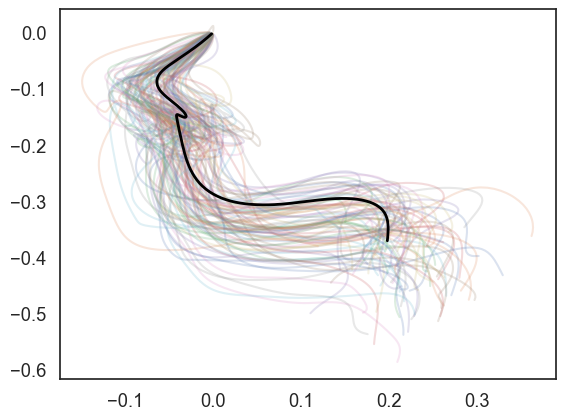

In [19]:
curves_r3 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=k_sampling_points+1, equip=False
)
curves_r3.equip_with_metric(SRVMetric)

mean = FrechetMean(curves_r3)
mean.fit(curve_cs)
mean_estimate = mean.estimate_

for i in range(len(curve_cs)):
    plt.plot(curve_cs[i][:, 0], curve_cs[i][:, 1],alpha=0.2)
plt.plot(mean_estimate[:, 0], mean_estimate[:, 1], color='black', linewidth=2, label='Frechet Mean')
plt.show()

tangent_base = mean.estimate_

tpca = TangentPCA(curves_r3, n_components=tPCA_N_COMPONENTS)
tpca.fit(curve_cs, base_point=tangent_base)
tangent_projected_data = tpca.transform(curve_cs)

C:\Users\cheno\AppData\Local\Temp\ipykernel_35020\3199906830.py:34: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



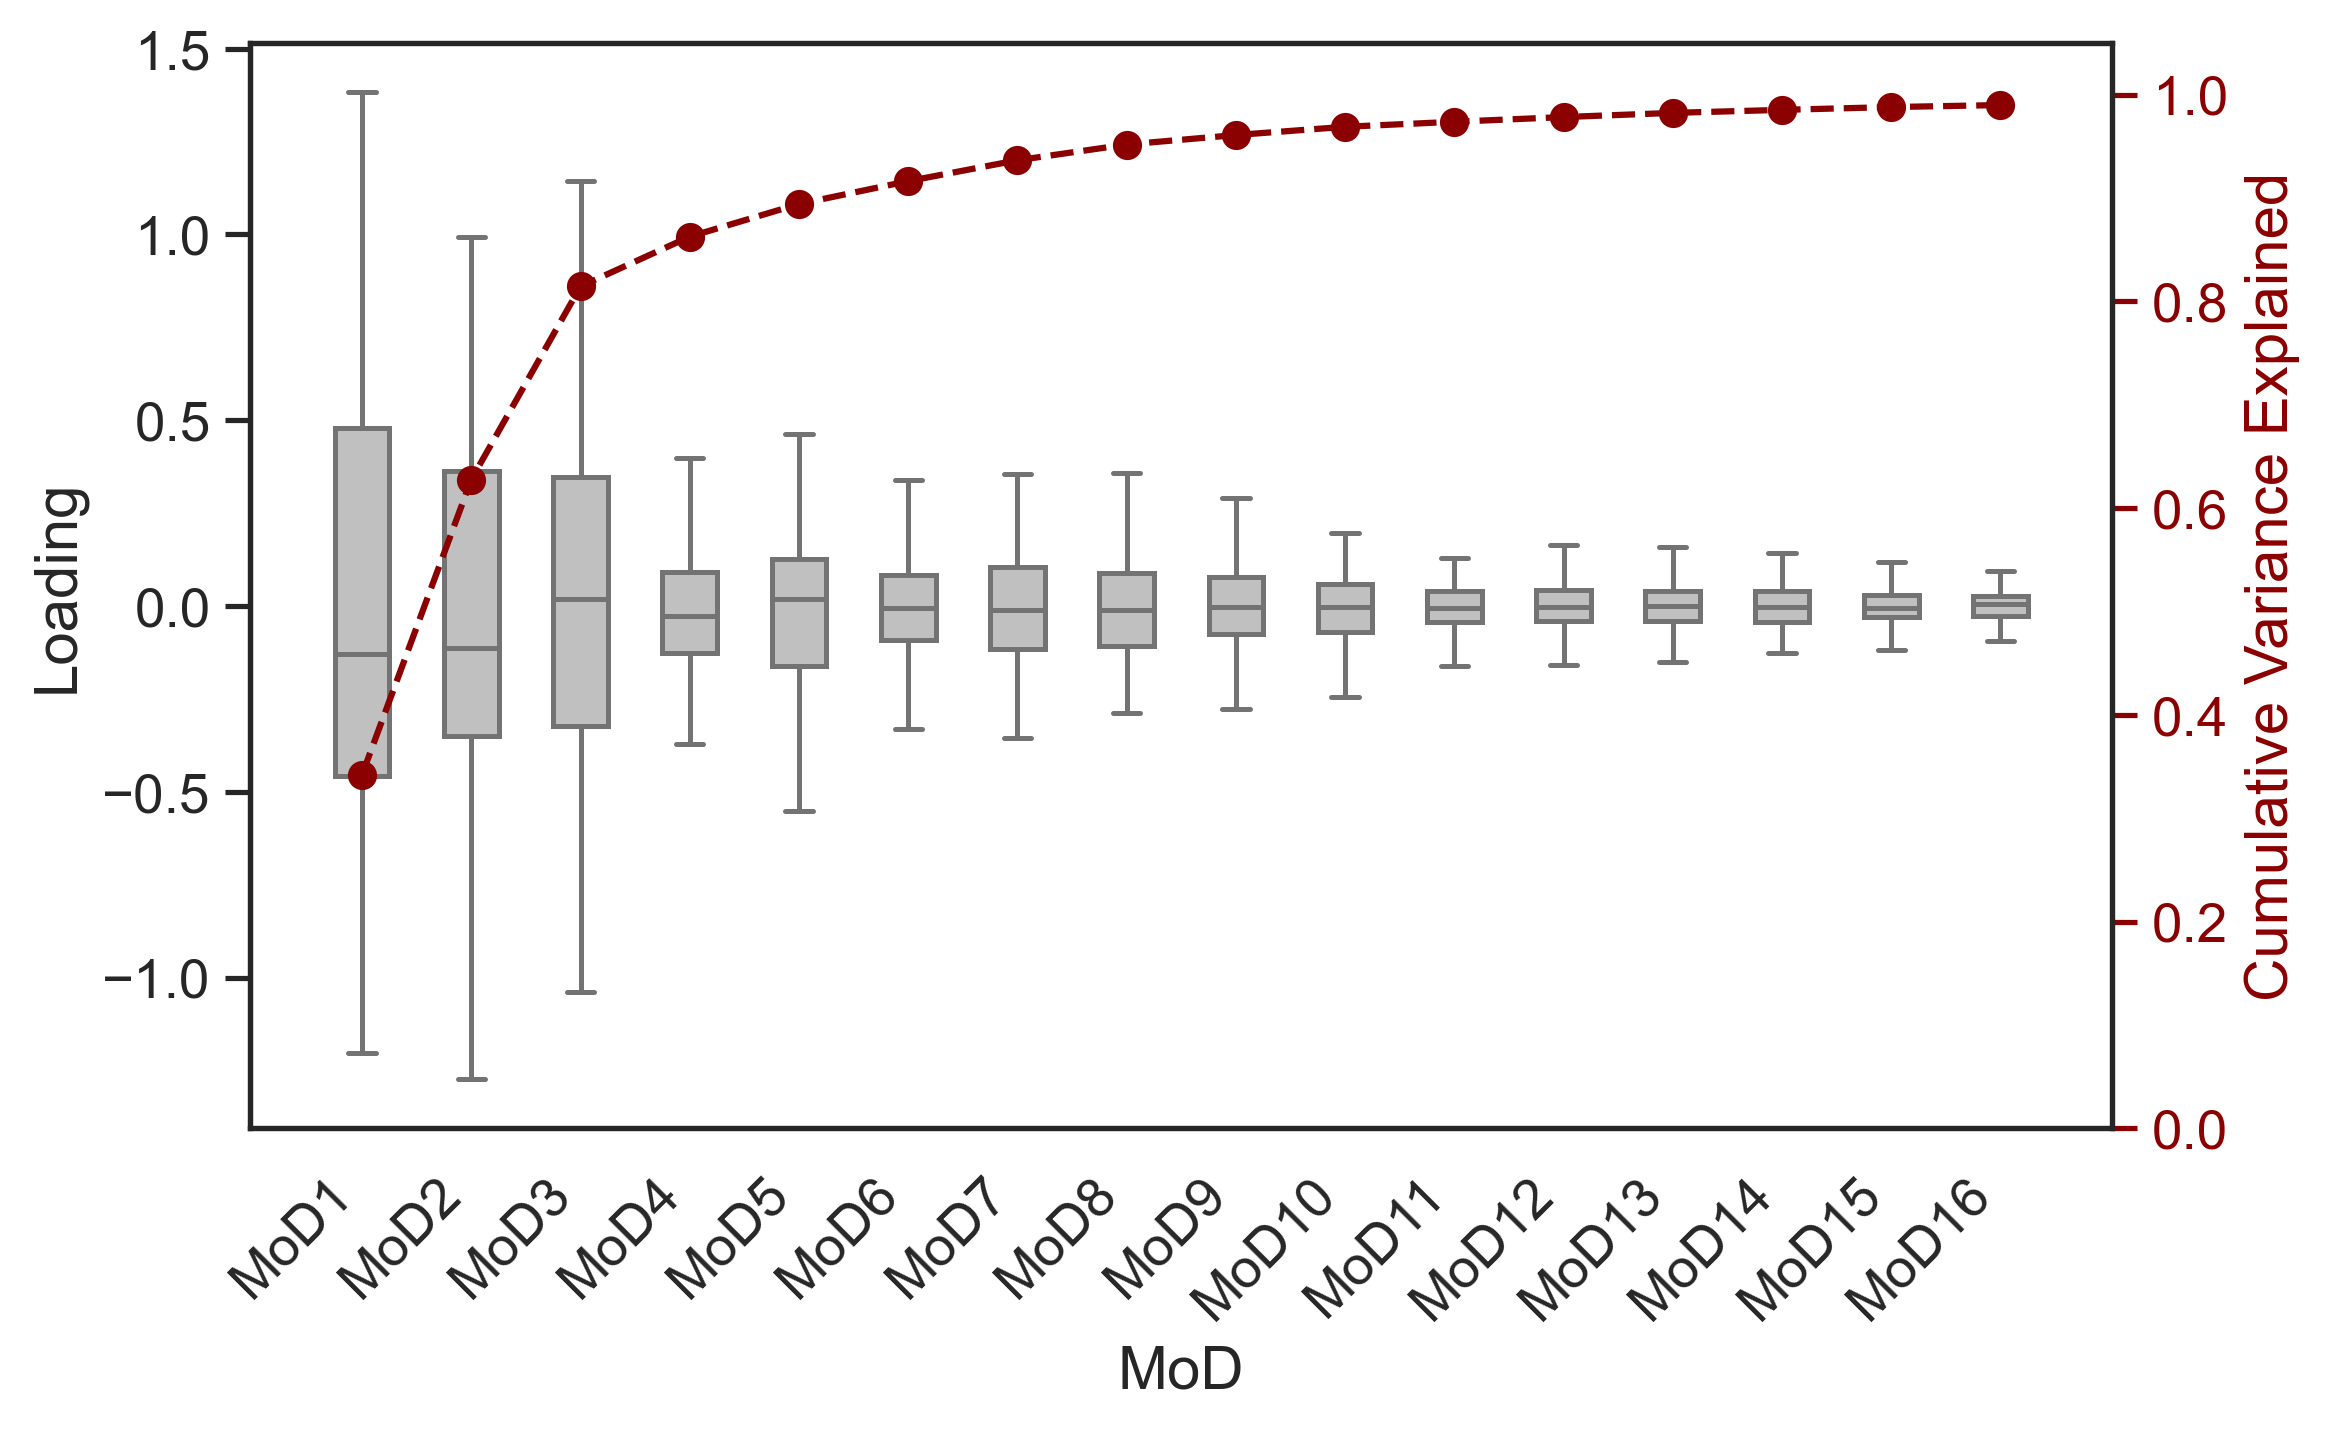

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 预先准备
explained_variance_ratio = tpca.explained_variance_ratio_
cumulative_ratio = np.cumsum(explained_variance_ratio)
labels_simple = [f"MoD{i+1}" for i in range(len(explained_variance_ratio))]

# 构建DataFrame以便使用seaborn绘图
n_components = tangent_projected_data.shape[1]
df = pd.DataFrame(tangent_projected_data, columns=[f"PC{i+1}" for i in range(n_components)])

# 转换为long-form格式以便violinplot
df_long = df.melt(var_name="MoD", value_name="Loading")


fig, ax1 = plt.subplots(figsize=(8, 5), dpi=300)

# 左侧y轴：boxplot
sns.boxplot(
    data=df_long,
    x="MoD",
    y="Loading",
    width=0.5,
    linewidth=1.2,
    showfliers=False,
    color="silver",
    ax=ax1
)

ax1.set_xlabel("MoD")
ax1.set_ylabel("Loading")
ax1.set_xticklabels(labels_simple, rotation=45, ha="right")

# 右侧y轴：累计解释率
ax2 = ax1.twinx()
ax2.plot(range(len(explained_variance_ratio)), cumulative_ratio, color='darkred', marker='o', linestyle='--', label='Cumulative Variance')
ax2.set_ylabel("Cumulative Variance Explained")
ax2.set_ylim(0, 1.05)

ax2.set_ylabel("Cumulative Variance Explained", color='darkred')
ax2.tick_params(axis='y', colors='darkred')

# 可选：加网格
ax1.grid(False)
ax2.grid(False)

# 可选：图例
# ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()



In [21]:
import numpy as np
import matplotlib.pyplot as plt
from geomstats.geometry.discrete_curves import DiscreteCurvesStartingAtOrigin, SRVMetric
from geomstats.learning.frechet_mean import FrechetMean

# 参数设定
pc_index = 0
scores = tangent_projected_data[:, pc_index]
threshold = np.median(scores)

# 根据 PC1 分组
high_group = curve_cs[scores > threshold]
low_group = curve_cs[scores <= threshold]

# 分别构建 manifold 对象（每组要单独构建，因为 manifold 中缓存了采样点数）
curves_r3_pc1_high = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=high_group.shape[1], equip=False
)
curves_r3_pc1_high.equip_with_metric(SRVMetric)

curves_r3_pc1_low = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=low_group.shape[1], equip=False
)
curves_r3_pc1_low.equip_with_metric(SRVMetric)

# 分别计算 Frechet Mean
mean_high = FrechetMean(curves_r3_pc1_high)
mean_high.fit(high_group)
mean_high_curve = mean_high.estimate_

mean_low = FrechetMean(curves_r3_pc1_low)
mean_low.fit(low_group)
mean_low_curve = mean_low.estimate_


diff = mean_high_curve - mean_low_curve
euclidean_diff_norm = np.linalg.norm(diff, axis=1)
total_diff = np.sum(euclidean_diff_norm) / len(euclidean_diff_norm)
print(f"Average Euclidean norm between mean curves: {total_diff:.6f}")

pca = PCA(n_components=3)
pca.fit(diff)

print("Explained variance ratio (directionality of shape change):", pca.explained_variance_ratio_)
print("Principal direction of shape difference (1st PC):", pca.components_[0])

import numpy as np
import plotly.graph_objects as go
from sklearn.decomposition import PCA

# 计算差值和主方向
diff = mean_high_curve - mean_low_curve
pca = PCA(n_components=3)
pca.fit(diff)
principal_direction = pca.components_[0]  # shape: (3,)

# 设置箭头的起点为 mean_low_curve 的中点
center_idx = len(mean_low_curve) // 2
arrow_start = mean_low_curve[center_idx]
arrow_dir = principal_direction * 0.1  # 调整长度以便可视化
arrow_end = arrow_start + arrow_dir

# 创建图形
fig = go.Figure()

# 添加平均曲线
fig.add_trace(go.Scatter3d(
    x=mean_low_curve[:, 0], y=mean_low_curve[:, 1], z=mean_low_curve[:, 2],
    mode='lines',
    name='Low PC1',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter3d(
    x=mean_high_curve[:, 0], y=mean_high_curve[:, 1], z=mean_high_curve[:, 2],
    mode='lines',
    name='High PC1',
    line=dict(color='red')
))

# 添加主方向箭头
fig.add_trace(go.Scatter3d(
    x=[arrow_start[0], arrow_end[0]],
    y=[arrow_start[1], arrow_end[1]],
    z=[arrow_start[2], arrow_end[2]],
    mode='lines+markers',
    name='Principal Direction',
    line=dict(color='black', width=6, dash='dot'),
    marker=dict(size=3, color='black')
))

fig.update_layout(
    title='PC1 Effect: High vs Low group with Principal Direction',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    width=800,
    height=600
)

fig.show()



Average Euclidean norm between mean curves: 0.060103
Explained variance ratio (directionality of shape change): [0.85349457 0.13135248 0.01515294]
Principal direction of shape difference (1st PC): [ 0.52472291 -0.4955257   0.69218506]


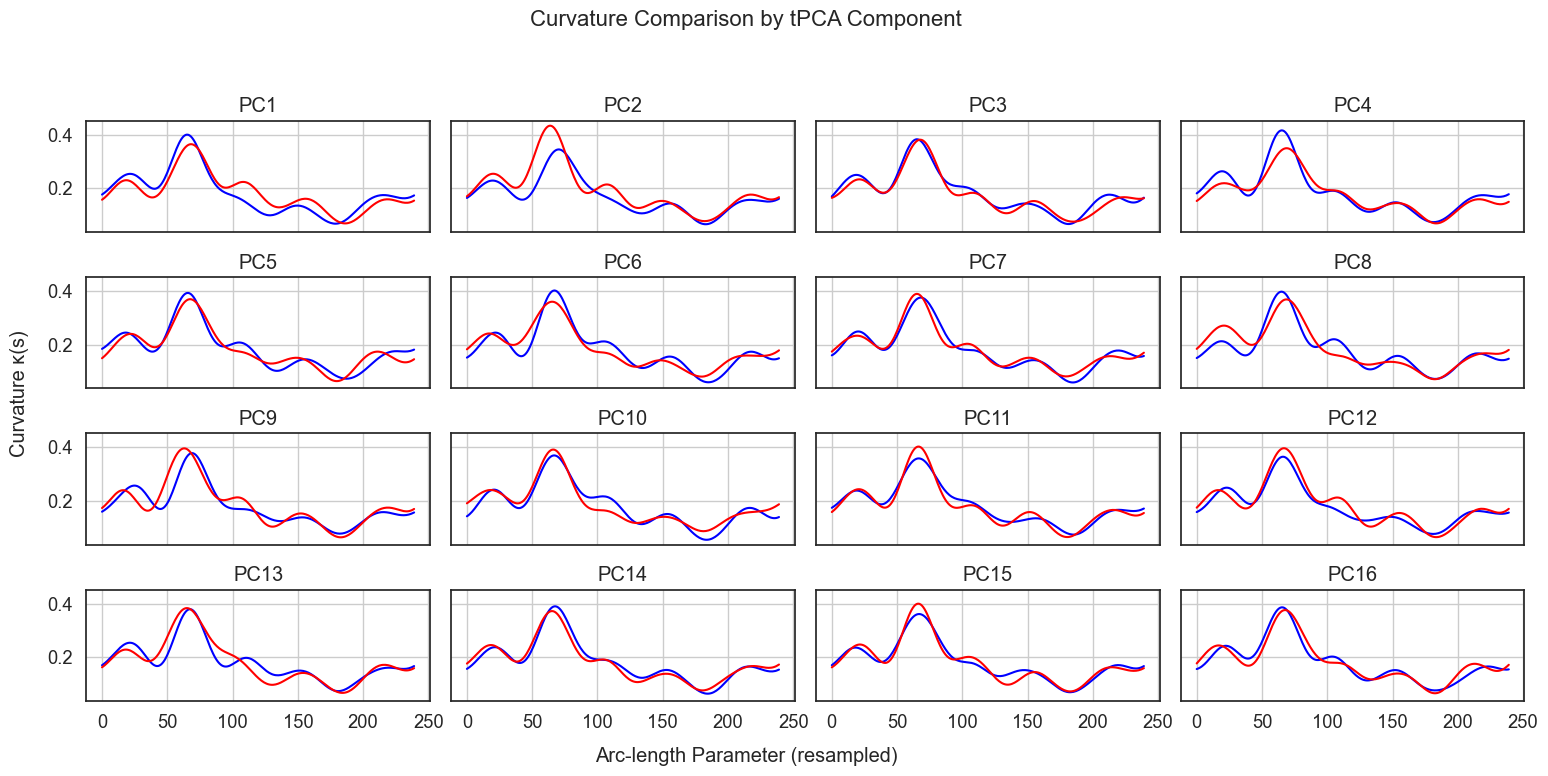

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# 参数
n_components = 16  # 总主成分数
n_cols = 4         # 每行放几个子图
n_rows = int(np.ceil(n_components / n_cols))  # 自动计算行数

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 2 * n_rows), sharex=True, sharey=True)

for pc_index in range(n_components):
    ax = axes.flat[pc_index]

    scores = tangent_projected_data[:, pc_index]
    threshold = np.median(scores)

    high_idx = scores > threshold
    low_idx = scores <= threshold

    mean_kappa_high_aligned = np.mean(f_weighted_unwrapped[:, high_idx], axis=1)
    mean_kappa_low_aligned = np.mean(f_weighted_unwrapped[:, low_idx], axis=1)
    mean_kappa_high = np.mean(np.array(resampled_curves)[high_idx, :], axis=0)
    mean_kappa_low = np.mean(np.array(resampled_curves)[low_idx, :], axis=0)

    ax.plot(mean_kappa_low, label='Low', color='blue')
    ax.plot(mean_kappa_high, label='High', color='red')
    # ax.plot(mean_kappa_high_aligned, label='High (Aligned)', color='red', linestyle='--')
    # ax.plot(mean_kappa_low_aligned, label='Low (Aligned)', color='blue', linestyle='--')
    ax.set_title(f'PC{pc_index + 1}')
    ax.grid(True)

# 去除多余子图
for i in range(n_components, n_rows * n_cols):
    fig.delaxes(axes.flat[i])

# 统一标签与布局
fig.suptitle('Curvature Comparison by tPCA Component', fontsize=16)
fig.text(0.5, 0.04, 'Arc-length Parameter (resampled)', ha='center')
fig.text(0.04, 0.5, 'Curvature κ(s)', va='center', rotation='vertical')
fig.tight_layout(rect=[0.05, 0.05, 1, 0.95])

plt.show()


In [23]:
print (np.array(resampled_curves).shape)

(91, 240)


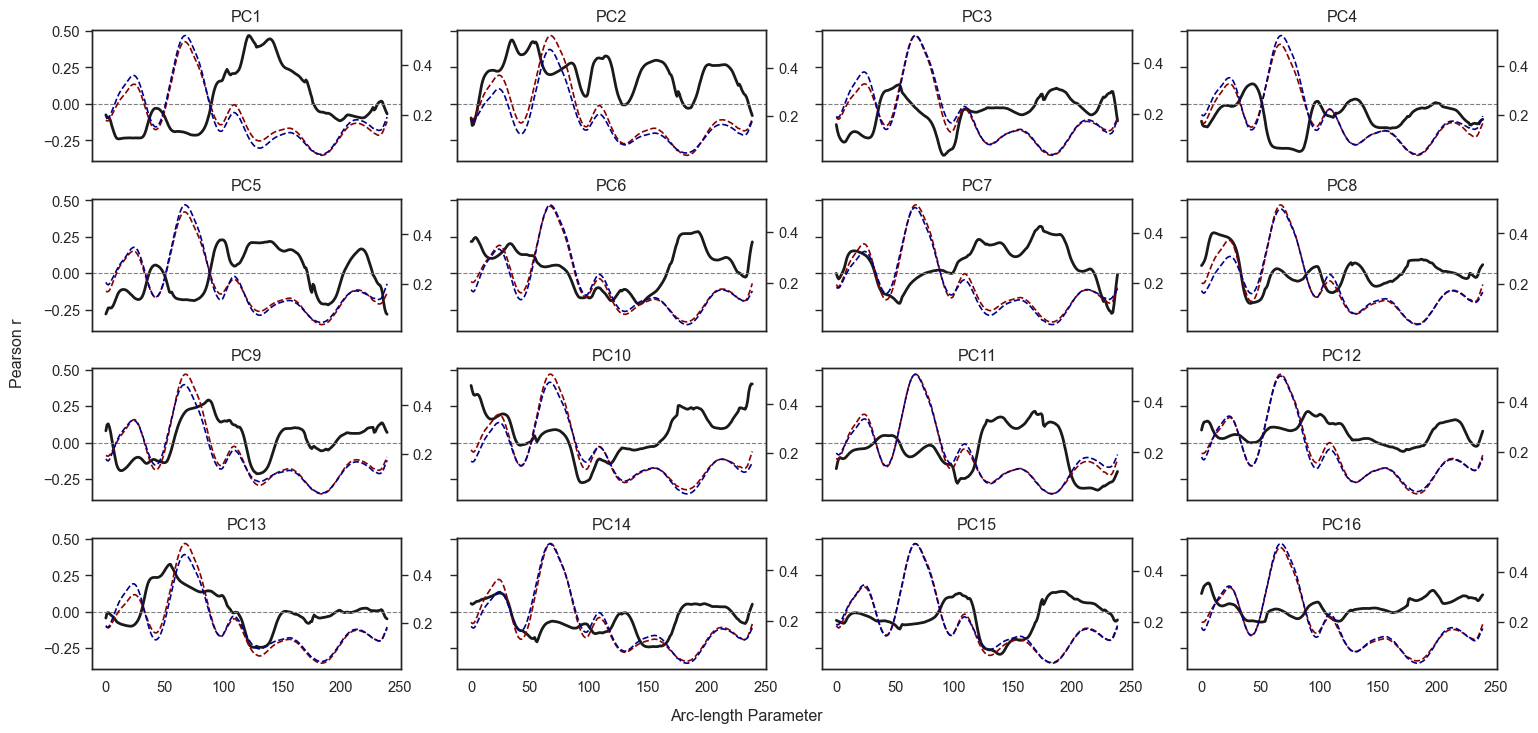

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr


sns.set(style="white", context="paper", font_scale=1.2)
# 参数
n_components = 16
n_cols = 4
n_rows = int(np.ceil(n_components / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 2 * n_rows), sharex=True, sharey=True)

for pc_index in range(n_components):
    ax = axes.flat[pc_index]
    pc_scores = tangent_projected_data[:, pc_index]

    # scores = tangent_projected_data[:, pc_index]
    threshold = np.median(pc_scores)

    high_idx = pc_scores > threshold
    low_idx = pc_scores <= threshold
    # print (f"PC{pc_index + 1}: High group size = {np.sum(high_idx)}, Low group size = {np.sum(low_idx)}")

    mean_kappa_high_aligned = np.mean(f_weighted_unwrapped[:, high_idx], axis=1)
    mean_kappa_low_aligned = np.mean(f_weighted_unwrapped[:, low_idx], axis=1)

    corrs = []
    for j in range(f_weighted_unwrapped.shape[0]):
        r, _ = pearsonr(pc_scores, f_weighted_unwrapped[j, :])
        corrs.append(r)

    corrs = np.array(corrs)

    ax.plot(corrs, color='k',linewidth=2, label='PC Score Correlation')

    ax_2 = ax.twinx()
    ax_2.plot(mean_kappa_high_aligned, color='darkred', linestyle='--', label='High (Aligned)')
    ax_2.plot(mean_kappa_low_aligned, color='darkblue', linestyle='--', label='Low (Aligned)')

    ax.axhline(0, linestyle='--', color='gray', linewidth=0.8)
    ax.set_title(f'PC{pc_index + 1}')
    ax.grid(False)
    ax_2.grid(False)

# 去除多余子图
for i in range(n_components, n_rows * n_cols):
    fig.delaxes(axes.flat[i])

# 总体标签与布局
# fig.suptitle('Pointwise Correlation: Curvature vs. tPCA Components', fontsize=16)
fig.text(0.5, 0.04, 'Arc-length Parameter', ha='center')
fig.text(0.04, 0.5, 'Pearson r', va='center', rotation='vertical')
fig.tight_layout(rect=[0.05, 0.05, 1, 0.95])

plt.show()


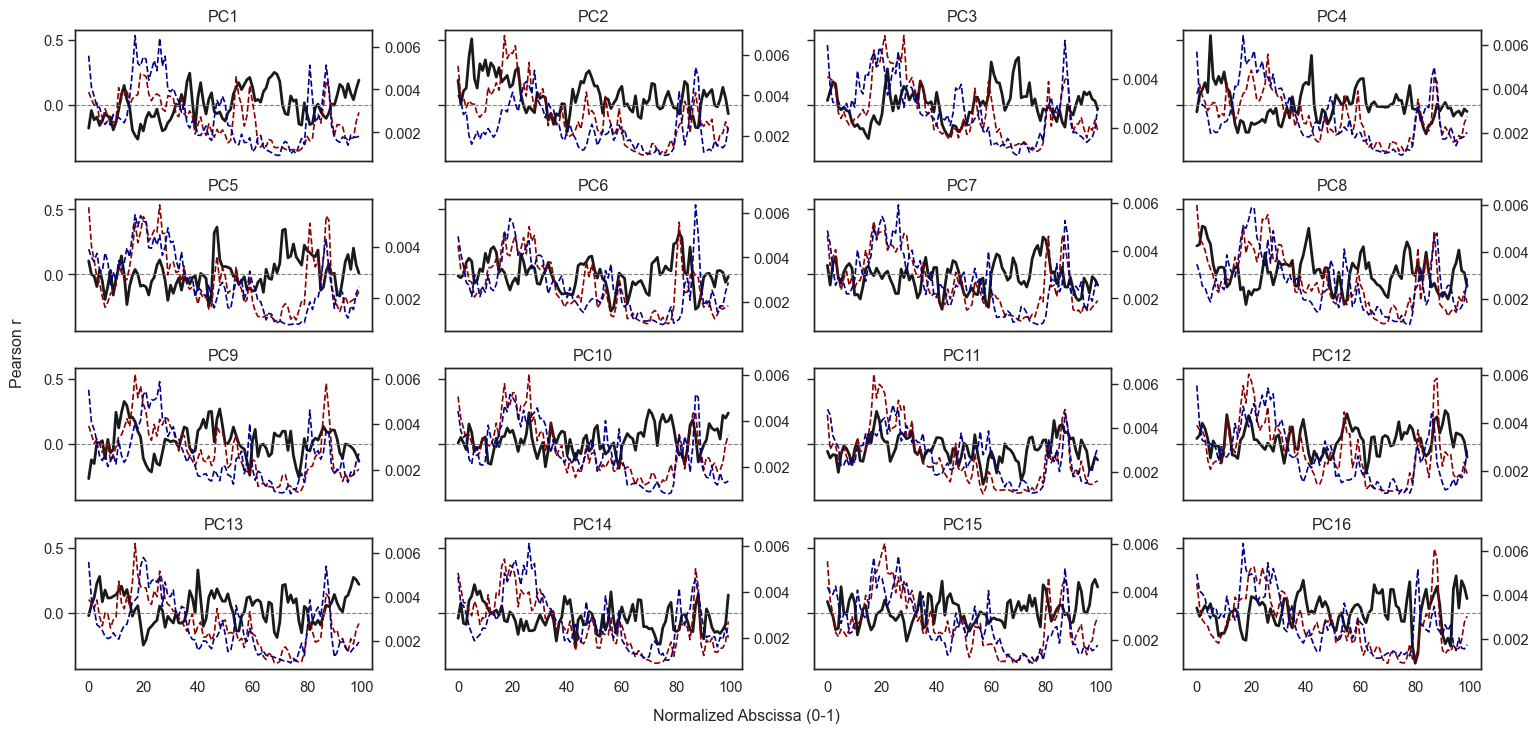

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# 假设前面已经准备好了
# tangent_projected_data: (n_samples, n_components)
# variation_matrix: (n_samples, num_points)

n_components = 16
n_cols = 4
n_rows = int(np.ceil(n_components / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 2 * n_rows), sharex=True, sharey=True)

for pc_index in range(n_components):
    ax = axes.flat[pc_index]
    pc_scores = tangent_projected_data[:, pc_index]

    threshold = np.median(pc_scores)
    high_idx = pc_scores > threshold
    low_idx = pc_scores <= threshold

    # 分组均值
    mean_variation_high = np.mean(variation_matrix[high_idx, :], axis=0)
    mean_variation_low = np.mean(variation_matrix[low_idx, :], axis=0)

    # 逐点相关
    corrs = []
    for j in range(variation_matrix.shape[1]):
        r, _ = pearsonr(pc_scores, variation_matrix[:, j])
        corrs.append(r)
    corrs = np.array(corrs)

    # 画
    ax.plot(corrs, color='k', linewidth=2, label='PC Score Correlation')

    ax_2 = ax.twinx()
    ax_2.plot(mean_variation_high, color='darkred', linestyle='--', label='High (Variation)')
    ax_2.plot(mean_variation_low, color='darkblue', linestyle='--', label='Low (Variation)')

    ax.axhline(0, linestyle='--', color='gray', linewidth=0.8)
    ax.set_title(f'PC{pc_index + 1}')
    ax.grid(False)
    ax_2.grid(False)

# 去掉多余子图
for i in range(n_components, n_rows * n_cols):
    fig.delaxes(axes.flat[i])

fig.text(0.5, 0.04, 'Normalized Abscissa (0-1)', ha='center')
fig.text(0.04, 0.5, 'Pearson r', va='center', rotation='vertical')
fig.tight_layout(rect=[0.05, 0.05, 1, 0.95])

plt.show()


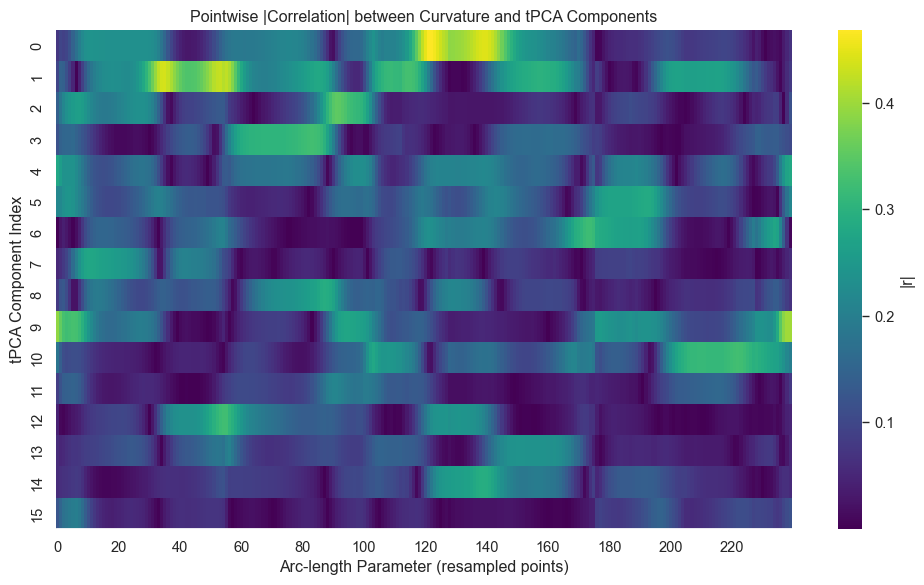

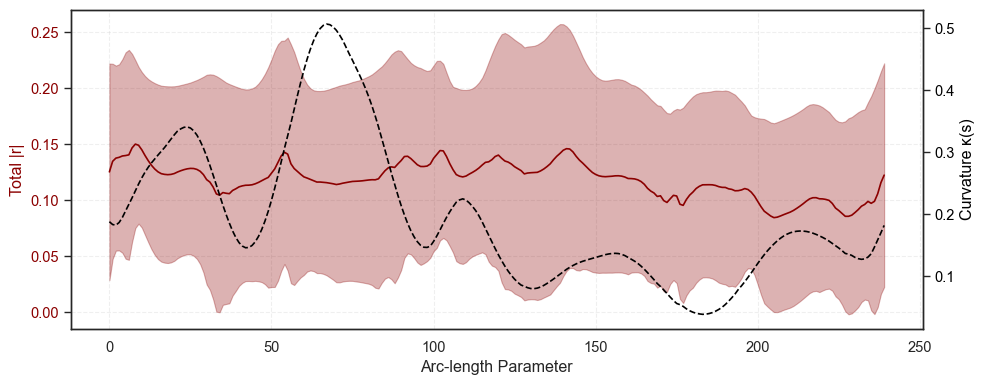

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

# Step 1: 构建相关矩阵 R (n_points, n_components)
n_components = tangent_projected_data.shape[1]
n_points = f_weighted_unwrapped.shape[0]
R = np.zeros((n_points, n_components))

for pc_index in range(n_components):
    pc_scores = tangent_projected_data[:, pc_index]
    for j in range(n_points):
        r, _ = pearsonr(pc_scores, f_weighted_unwrapped[j, :])
        R[j, pc_index] = r

# Step 2: 计算每个点的影响模式
# 模式强度特征
abs_R = np.abs(R)
max_r = np.max(abs_R, axis=1)
mean_r = np.mean(abs_R, axis=1)
std_r = np.std(abs_R, axis=1)


# Step 4: 可视化热图
plt.figure(figsize=(10, 6))
sns.heatmap(abs_R.T, cmap='viridis', cbar_kws={'label': '|r|'}, xticklabels=20)
plt.axhline(y=n_components, color='white', linewidth=2)
plt.xlabel("Arc-length Parameter (resampled points)")
plt.ylabel("tPCA Component Index")
plt.title("Pointwise |Correlation| between Curvature and tPCA Components")
plt.tight_layout()
plt.show()

# Step 5: 计算每个点的整体影响强度
influence_score = np.sum(abs_R, axis=1)/tPCA_N_COMPONENTS  # shape: (n_points,)
influence_std = np.std(abs_R, axis=1)  # shape: (n_points,)

# 可视化影响强度曲线 + 曲率均值 + 标准差区域
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

# 主图：influence_score（红线）+ 标准差阴影
x = np.arange(len(influence_score))
ax1.plot(x, influence_score, color='darkred', label='Mean |r|')
ax1.fill_between(
    x,
    influence_score - influence_std,
    influence_score + influence_std,
    color='darkred',
    alpha=0.3,
    label='±1 std'
)

# 辅助图：曲率均值
ax2.plot(f_weighted_unwrapped.mean(axis=1), color='black', linestyle='--', label='Mean κ(s)')

# 标签与美化
ax1.set_xlabel("Arc-length Parameter")
ax1.set_ylabel("Total |r|", color='darkred')
ax2.set_ylabel("Curvature κ(s)", color='black')
ax1.tick_params(axis='y', labelcolor='darkred')
ax2.tick_params(axis='y', labelcolor='black')
ax1.grid(True, linestyle='--', alpha=0.3)

fig.tight_layout()
plt.show()



In [27]:
# from scipy.signal import find_peaks

# # Step 5: 计算每个点的整体影响强度
# influence_score = np.sum(abs_R, axis=1) / tPCA_N_COMPONENTS  # shape: (n_points,)
# influence_std = np.std(abs_R, axis=1)  # shape: (n_points,)

# # Step 6: 找到平均曲率的峰值位置
# mean_curvature = f_weighted_unwrapped.mean(axis=1)
# peaks, _ = find_peaks(mean_curvature, distance=5)

# # Step 7: 找出每个峰值位置最强的前5个 tPC 分量及其影响强度
# topk = 5
# top_tpcs = np.argsort(abs_R[peaks], axis=1)[:, -topk:][:, ::-1]  # shape: (n_peaks, 5)
# top_vals = np.take_along_axis(abs_R[peaks], top_tpcs, axis=1)   # shape: (n_peaks, 5)

# # 可视化
# fig = plt.figure(figsize=(12, 5))
# ax1 = fig.add_subplot(111)
# ax2 = ax1.twinx()

# x = np.arange(len(influence_score))
# ax1.plot(x, influence_score, color='darkred', label='Mean |r|')
# ax1.fill_between(
#     x,
#     influence_score - influence_std,
#     influence_score + influence_std,
#     color='darkred',
#     alpha=0.3,
#     label='±1 std'
# )

# ax2.plot(mean_curvature, color='black', linestyle='--', label='Mean κ(s)')

# # Step 8: 标注每个峰值的前5个影响最大PC
# for i, idx in enumerate(peaks):
#     ax1.axvline(idx, color='darkred', linestyle=':', alpha=0.7)
#     label_text = '\n'.join([f" PC{pc+1}: {val:.2f}" for pc, val in zip(top_tpcs[i], top_vals[i])])
#     ax1.text(idx, influence_score[idx] + 0.02, label_text,
#              color='darkred', fontsize=8, ha='left', va='bottom')

# # 标签与美化
# ax1.set_xlabel("Arc-length Parameter")
# ax1.set_ylabel("Total |r|", color='darkred')
# ax2.set_ylabel("Curvature κ(s)", color='black')
# ax1.tick_params(axis='y', labelcolor='darkred')
# ax2.tick_params(axis='y', labelcolor='black')
# ax1.grid(False)
# ax2.grid(False)

# fig.tight_layout()
# plt.show()


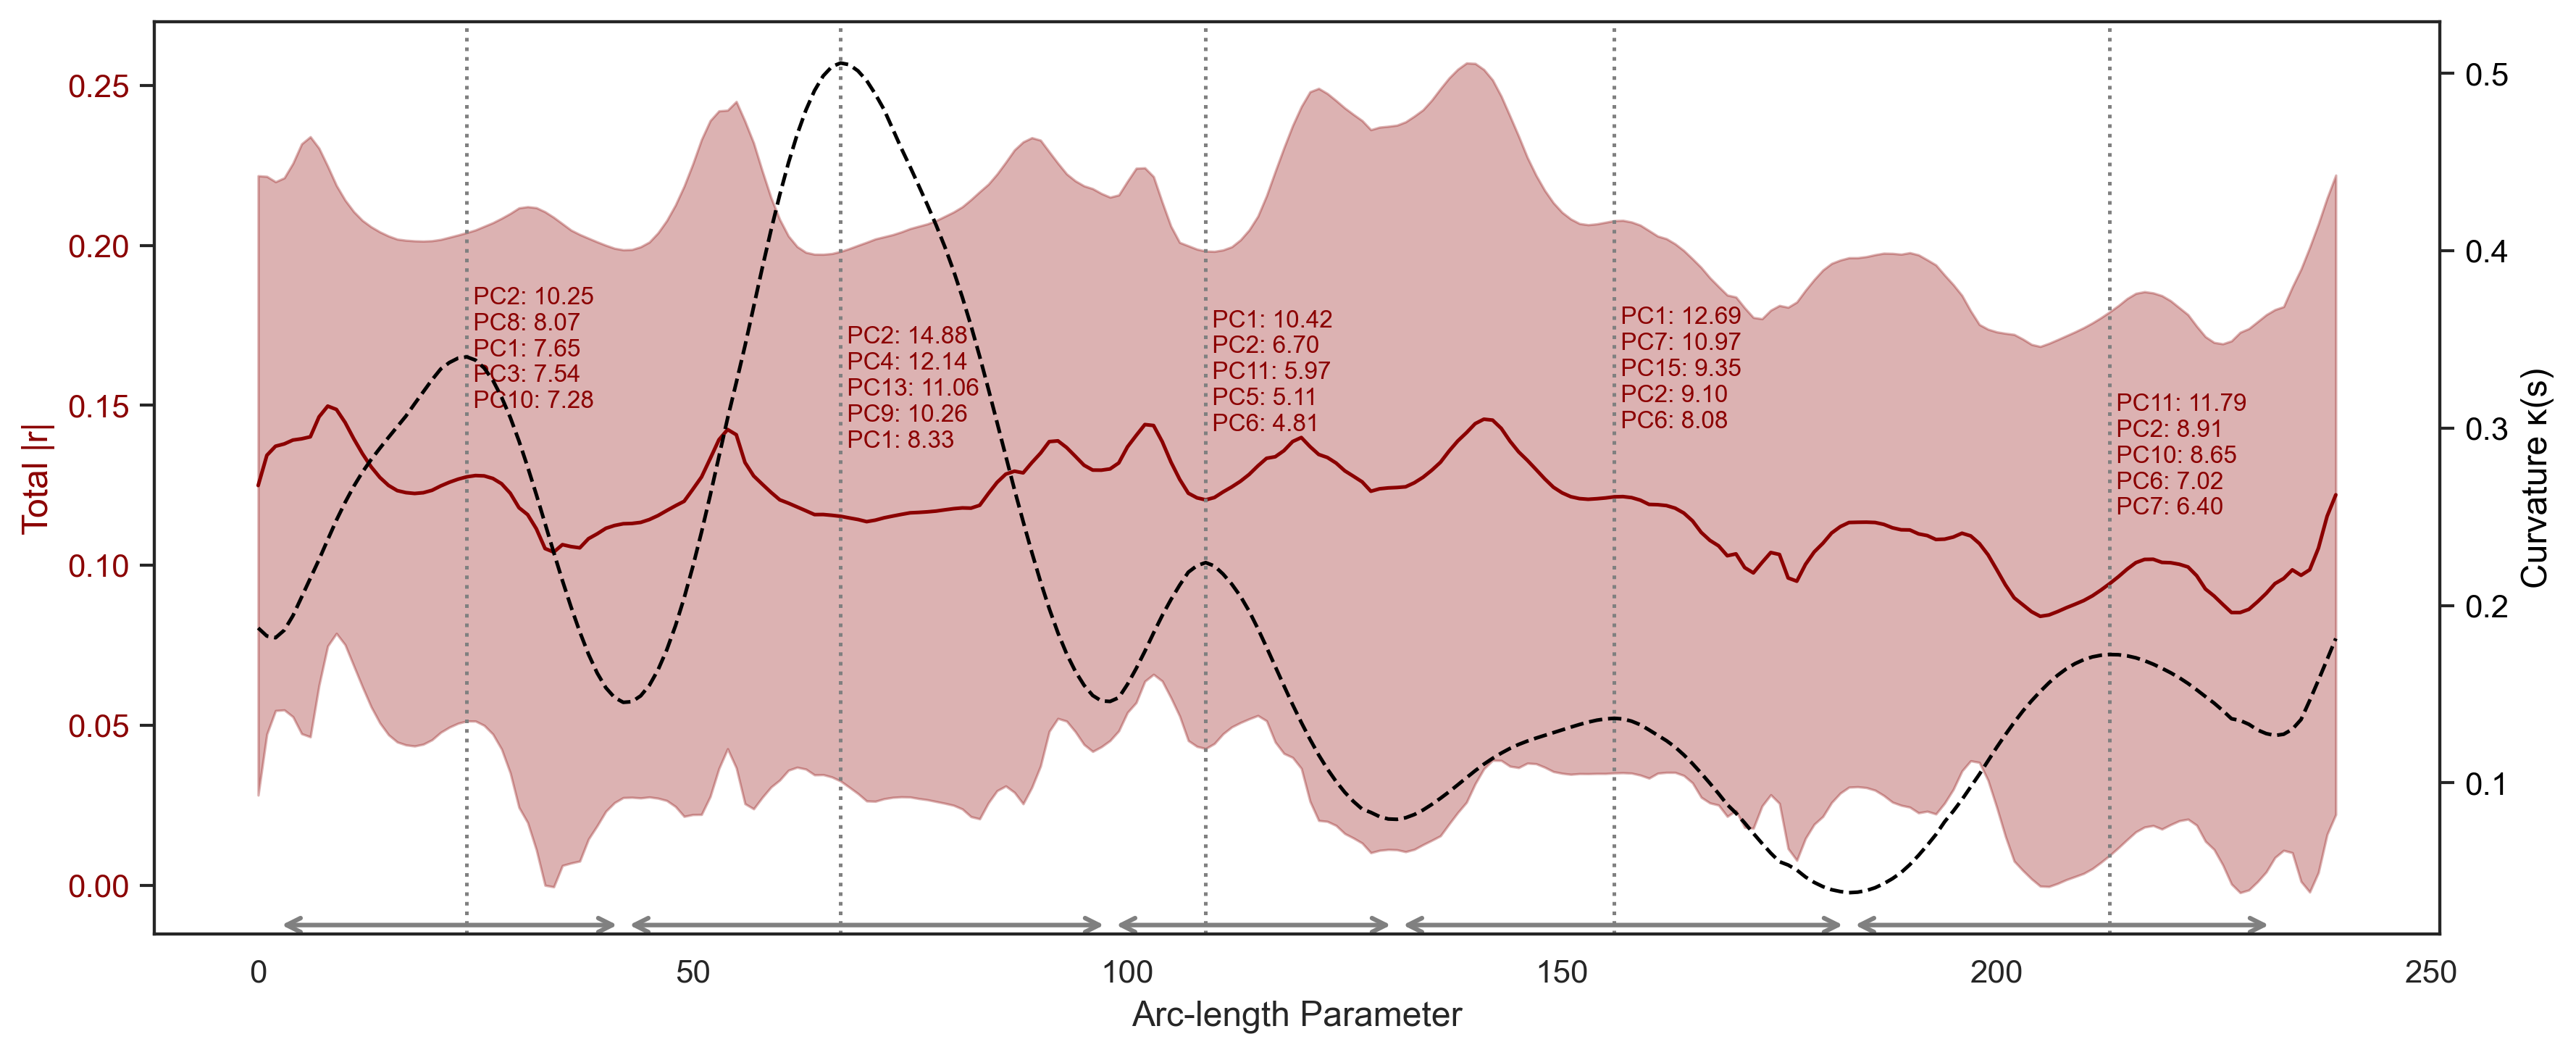

In [28]:
from scipy.signal import find_peaks

# Step 5: 计算每个点的整体影响强度
influence_score = np.sum(abs_R, axis=1) / tPCA_N_COMPONENTS
influence_std = np.std(abs_R, axis=1)

# Step 6: 计算平均曲率并找出波峰与波谷
mean_curvature = f_weighted_unwrapped.mean(axis=1)
peaks, _ = find_peaks(mean_curvature, distance=5)
valleys, _ = find_peaks(-mean_curvature, distance=5)

# Step 7: 对每个波峰，在其相邻波谷范围内整合abs_R
topk = 5
top_tpcs = []
top_vals = []

for peak in peaks:
    # 找左波谷：小于当前peak的最大valley
    left_valley_candidates = valleys[valleys < peak]
    left = left_valley_candidates[-1] if len(left_valley_candidates) > 0 else 0

    # 找右波谷：大于当前peak的最小valley
    right_valley_candidates = valleys[valleys > peak]
    right = right_valley_candidates[0] if len(right_valley_candidates) > 0 else abs_R.shape[0] - 1

    # 在区间 [left, right] 内对每个tPC累加影响
    region_r = abs_R[left:right + 1, :]  # shape: (region_len, n_components)
    summed_r = np.sum(region_r, axis=0)  # shape: (n_components,)

    # 找出 top-k tPC
    top_pc_indices = np.argsort(summed_r)[-topk:][::-1]
    top_pc_values = summed_r[top_pc_indices]

    top_tpcs.append(top_pc_indices)
    top_vals.append(top_pc_values)

top_tpcs = np.array(top_tpcs)
top_vals = np.array(top_vals)

# 可视化
fig = plt.figure(figsize=(12, 5),dpi=300)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

x = np.arange(len(influence_score))
ax1.plot(x, influence_score, color='darkred', label='Mean |r|')
ax1.fill_between(
    x,
    influence_score - influence_std,
    influence_score + influence_std,
    color='darkred',
    alpha=0.3,
    label='±1 std'
)

ax2.plot(mean_curvature, color='black', linestyle='--', label='Mean κ(s)')

# 标注每个峰值区间的前5个影响最大tPC及其影响值
for i, idx in enumerate(peaks):
    # 取出区间左右边界
    left_valley_candidates = valleys[valleys < idx]
    left = left_valley_candidates[-1] if len(left_valley_candidates) > 0 else 0
    right_valley_candidates = valleys[valleys > idx]
    right = right_valley_candidates[0] if len(right_valley_candidates) > 0 else abs_R.shape[0] - 1

    # 竖线标注峰值
    ax1.axvline(idx, color='gray', linestyle=':', alpha=1)

    # 箭头/横线：从 left 到 right，紧贴 x 轴底部
    y_arrow = ax1.get_ylim()[0] + 0.01 * (ax1.get_ylim()[1] - ax1.get_ylim()[0])
    ax1.annotate('', xy=(right, y_arrow), xytext=(left, y_arrow),
                 arrowprops=dict(arrowstyle='<->', color='gray', lw=1.5), annotation_clip=False)

    # 文字标注
    label_text = '\n'.join([f" PC{pc+1}: {val:.2f}" for pc, val in zip(top_tpcs[i], top_vals[i])])
    ax1.text(idx, influence_score[idx] + 0.02, label_text,
             color='darkred', fontsize=8, ha='left', va='bottom')

# 图美化
ax1.set_xlabel("Arc-length Parameter")
ax1.set_ylabel("Total |r|", color='darkred')
ax2.set_ylabel("Curvature κ(s)", color='black')
ax1.tick_params(axis='y', labelcolor='darkred')
ax2.tick_params(axis='y', labelcolor='black')
ax1.grid(False)
ax2.grid(False)

fig.tight_layout()
plt.show()


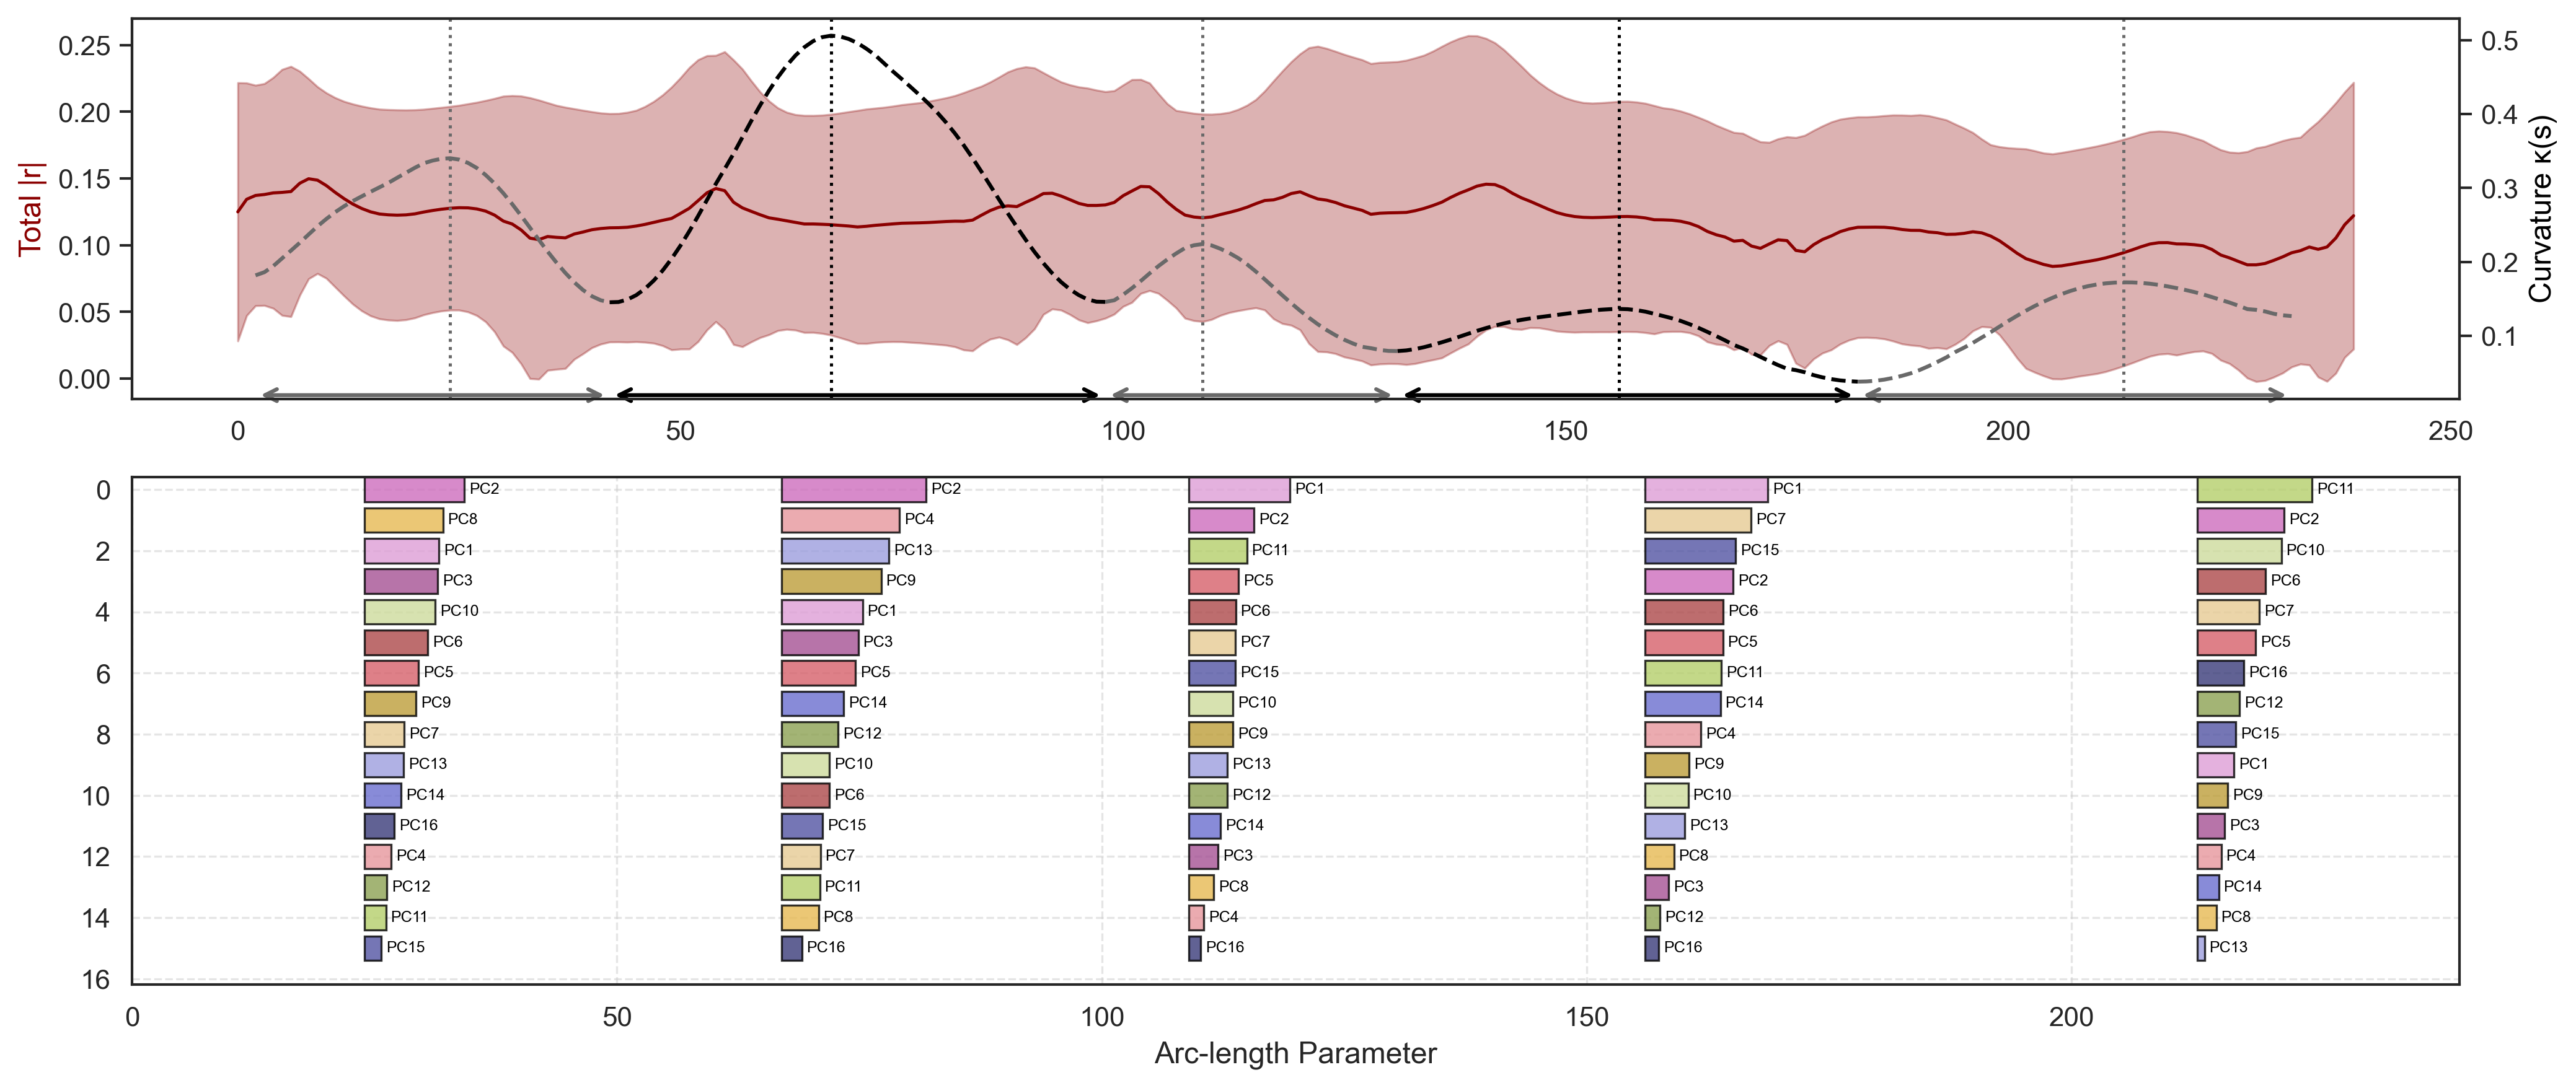

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore, entropy
from scipy.signal import find_peaks

# 假设你已有：
# abs_R: shape (n_points, n_components)
# f_weighted_unwrapped: curvature matrix
# influence_score, influence_std
sns.set_context('paper' , font_scale=1.2)
mean_curvature = f_weighted_unwrapped.mean(axis=1)
peaks, _ = find_peaks(mean_curvature, distance=5)
valleys, _ = find_peaks(-mean_curvature, distance=5)

interval_contribs = []
interval_zscores = []
interval_entropy = []
interval_bounds = []
interval_centers = []

for idx in peaks:
    left = valleys[valleys < idx][-1] if np.any(valleys < idx) else 0
    right = valleys[valleys > idx][0] if np.any(valleys > idx) else abs_R.shape[0] - 1
    region_r = abs_R[left:right + 1, :]
    summed_r = np.sum(region_r, axis=0)
    z = zscore(summed_r)
    e = entropy(summed_r / np.sum(summed_r))

    interval_contribs.append(summed_r)
    interval_zscores.append(z)
    interval_entropy.append(e)
    interval_bounds.append((left, right))
    interval_centers.append(idx)

interval_contribs = np.array(interval_contribs)       # (n_peaks, n_components)
interval_zscores = np.array(interval_zscores)         # (n_peaks, n_components)
interval_entropy = np.array(interval_entropy)         # (n_peaks,)
interval_centers = np.array(interval_centers)         # (n_peaks,)
n_components = abs_R.shape[1]

# 可视化
fig = plt.figure(figsize=(14, 6), dpi=300)
gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[2, n_components / 6])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# 上图：influence + curvature + entropy + 区间箭头
x = np.arange(len(influence_score))
ax1.plot(x, influence_score, color='darkred', label='Mean |r|')
ax1.fill_between(x, influence_score - influence_std, influence_score + influence_std,
                 color='darkred', alpha=0.3)
ax1_2 = ax1.twinx()
# ax1_2.plot(mean_curvature, color='black', linestyle='--', label='Mean κ(s)')
# 给每个区间分配颜色（从 tab10 colormap 中取）

interval_colors = ['dimgray', 'black']  # 两种颜色交替

for i, (left, right) in enumerate(interval_bounds):
    ax1_2.plot(np.arange(left, right + 1), mean_curvature[left:right + 1],
               linestyle='--', color=interval_colors[i % 2], linewidth=1.5)

for i, idx in enumerate(interval_centers):
    left, right = interval_bounds[i]
    color = interval_colors[i % 2]
    
    ax1.axvline(idx, color=color, linestyle=':', alpha=1)
    y_arrow = ax1.get_ylim()[0] + 0.01 * (ax1.get_ylim()[1] - ax1.get_ylim()[0])
    ax1.annotate('', xy=(right, y_arrow), xytext=(left, y_arrow),
                 arrowprops=dict(arrowstyle='<->', color=color, lw=1.5), annotation_clip=False)


ax1.set_ylabel("Total |r|", color='darkred')
ax1_2.set_ylabel("Curvature κ(s)", color='black')

# 下图：每个峰值一列，按照贡献从大到小排列的横向条形图（每行为一个rank）
bar_width = 0.8
colors = plt.cm.tab20b_r(np.linspace(0, 1, n_components))
pc_color_map = {pc: colors[pc] for pc in range(n_components)}

for peak_idx, center in enumerate(interval_centers):
    contribs = interval_contribs[peak_idx]
    sorted_indices = np.argsort(contribs)[::-1]  # 降序排列

    for rank, pc in enumerate(sorted_indices):
        width = contribs[pc]
        ax2.bar(x=center, height=bar_width, width=width,
                bottom=rank - bar_width / 2,
                color=pc_color_map[pc], alpha=0.8, align='edge', edgecolor='black')

        ax2.text(center + width + 0.5, rank, f"PC{pc+1}",
                 fontsize=6, color='black', va='center')

# ax2.set_yticks(np.arange(n_components))
# ax2.set_yticklabels([f"Rank {i+1}" for i in range(n_components)])
ax2.set_xlim(0, len(influence_score))
ax2.set_xlabel("Arc-length Parameter")
ax2.invert_yaxis()
ax1.grid(False)
ax1_2.grid(False)
ax2.grid(True, linestyle='--', alpha=0.5)

fig.tight_layout()
plt.show()


# To-Do: 需要把对齐改成以C1为中心

Identified 5 peaks (C0 ~ C4)
C1 Index: 67, C1 Time (normalized): 0.2803


c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



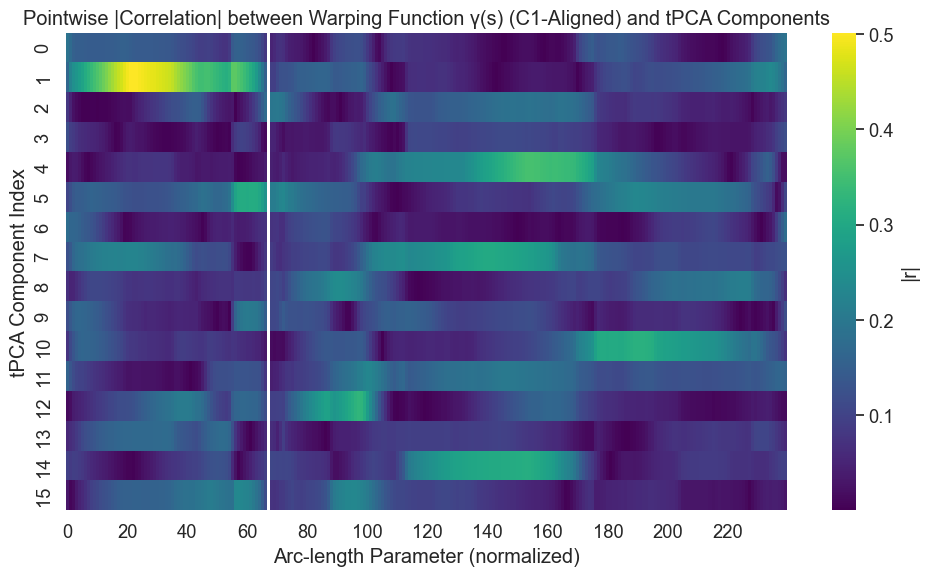

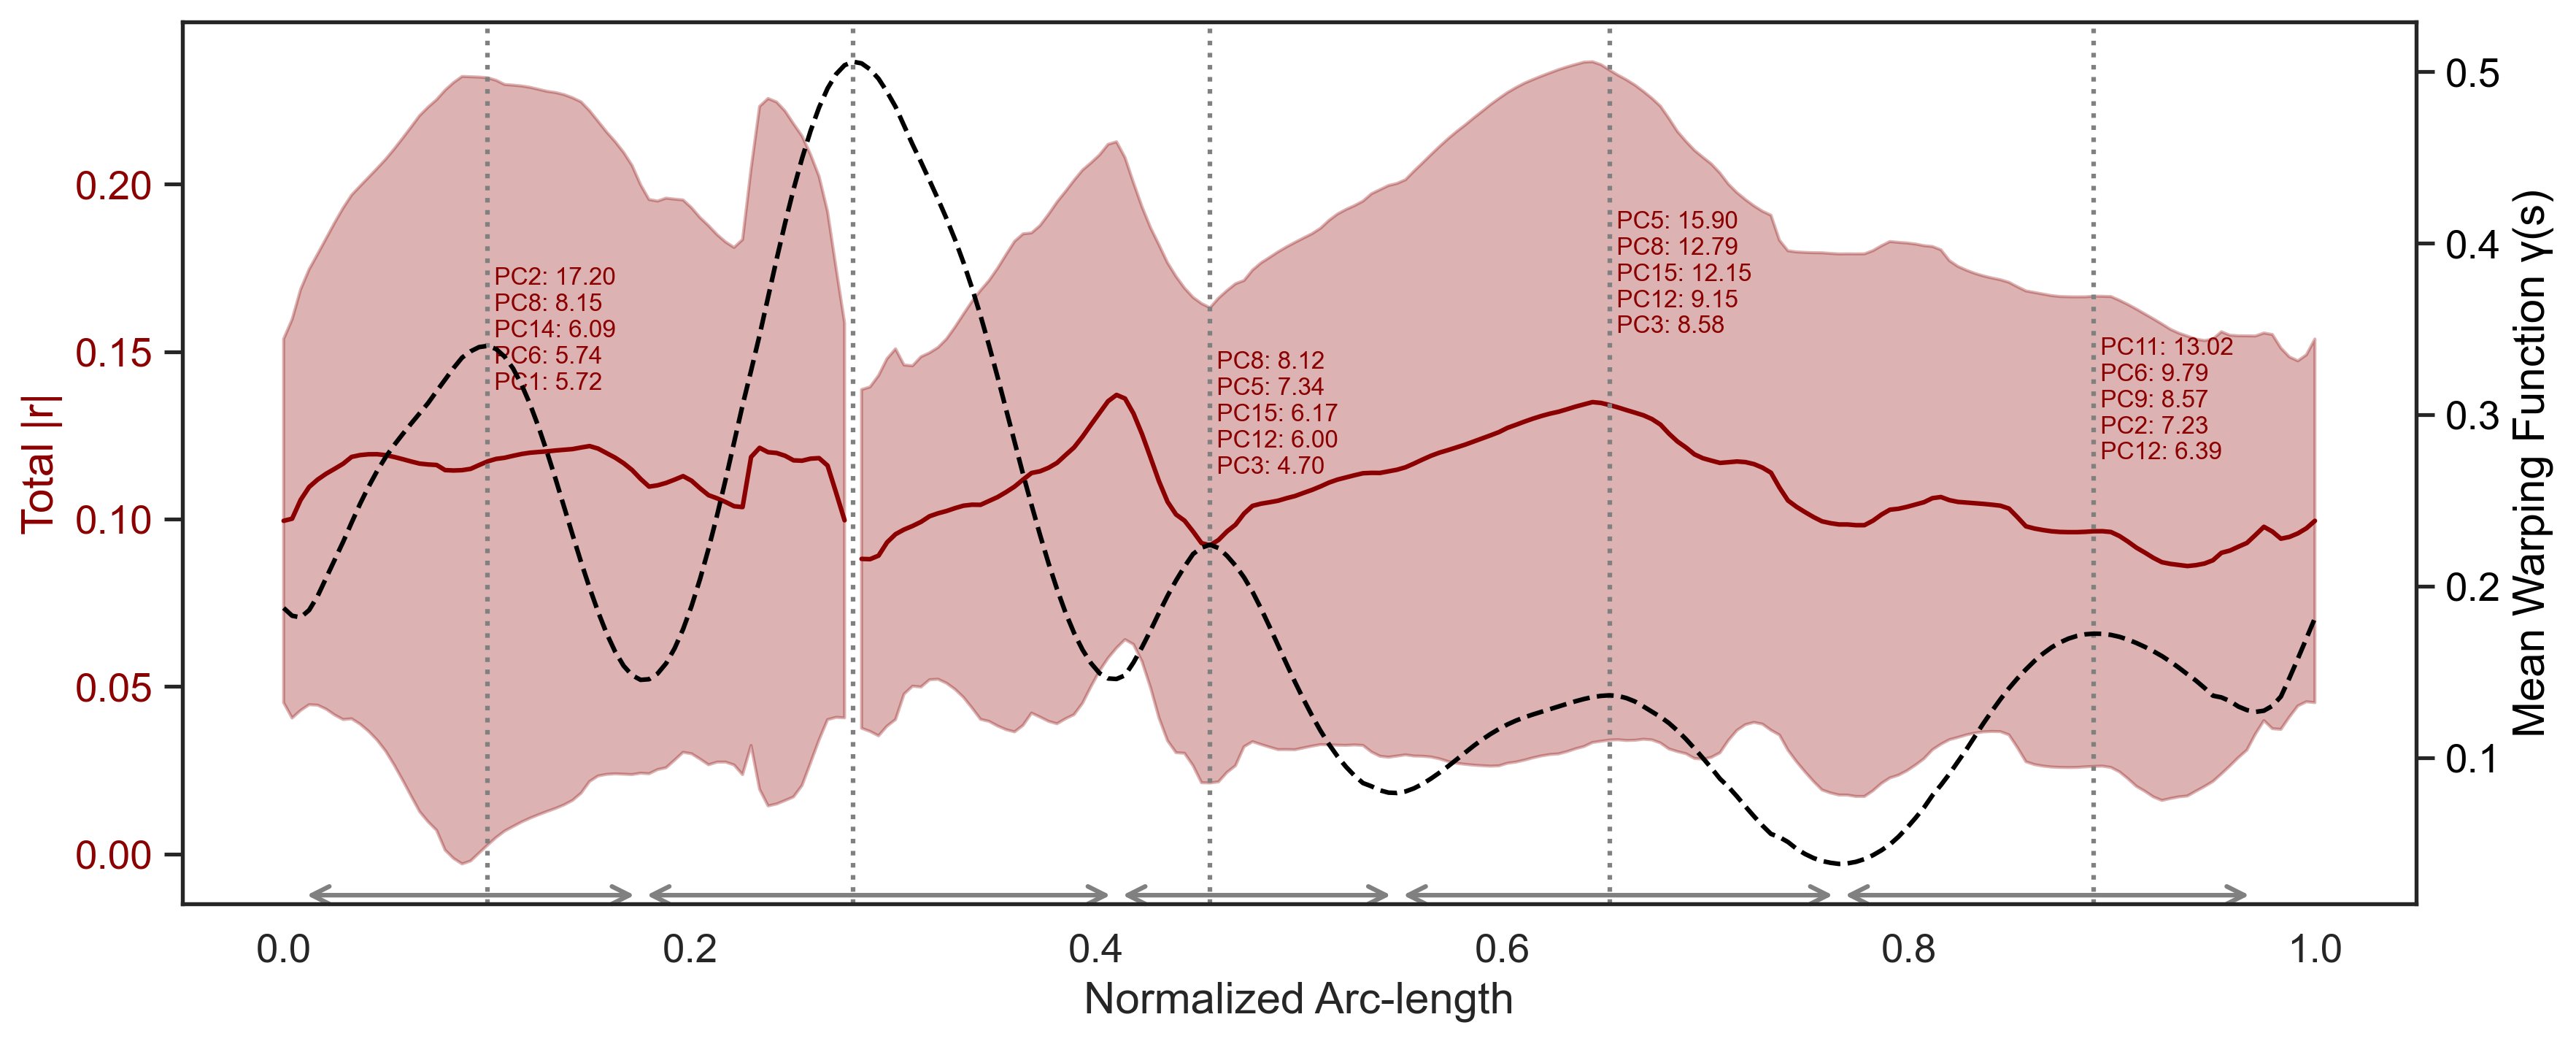

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
from scipy.signal import find_peaks

sns.set(style="white", context="notebook", font_scale=1.2)

# ------------------------------------------------------------
# 1️⃣ 基础定义
gammas_raw = obj_weighted.gam.T    # shape (n_samples, n_points)
time_grid = time                   # normalized arc-length [0,1]
n_samples, n_points = gammas_raw.shape

# ------------------------------------------------------------
# 2️⃣ 使用 mean_curvature 找到所有peaks
mean_curvature = f_weighted_unwrapped.mean(axis=1)
peaks, _ = find_peaks(mean_curvature, distance=5)
valleys, _ = find_peaks(-mean_curvature, distance=5)

print(f"Identified {len(peaks)} peaks (C0 ~ C{len(peaks)-1})")

# ------------------------------------------------------------
# 3️⃣ 以C1为对齐基准
c1_idx = peaks[1]
c1_time = time_grid[c1_idx]
print(f"C1 Index: {c1_idx}, C1 Time (normalized): {c1_time:.4f}")

gammas_aligned = np.zeros_like(gammas_raw)
for i in range(n_samples):
    offset = gammas_raw[i, c1_idx] - c1_time
    gammas_aligned[i, :] = gammas_raw[i, :] - offset

# ------------------------------------------------------------
# 4️⃣ 构建相关矩阵 R_gamma
n_components = tangent_projected_data.shape[1]
R_gamma = np.zeros((n_points, n_components))

for pc_index in range(n_components):
    pc_scores = tangent_projected_data[:, pc_index]
    for j in range(n_points):
        r, _ = pearsonr(pc_scores, gammas_aligned[:, j])
        R_gamma[j, pc_index] = r

# ------------------------------------------------------------
# 5️⃣ 统计模式强度
abs_R_gamma = np.abs(R_gamma)
mean_r_gamma = np.mean(abs_R_gamma, axis=1)
std_r_gamma = np.std(abs_R_gamma, axis=1)

# ------------------------------------------------------------
# 6️⃣ 每个mean_curve的峰值区间内的 top-k tPC 分析
topk = 5
top_tpcs = []
top_vals = []

for peak in peaks:
    left_valley_candidates = valleys[valleys < peak]
    left = left_valley_candidates[-1] if len(left_valley_candidates) > 0 else 0

    right_valley_candidates = valleys[valleys > peak]
    right = right_valley_candidates[0] if len(right_valley_candidates) > 0 else abs_R_gamma.shape[0] - 1

    region_r = abs_R_gamma[left:right + 1, :]  # (region_len, n_components)
    summed_r = np.sum(region_r, axis=0)        # (n_components,)

    top_pc_indices = np.argsort(summed_r)[-topk:][::-1]
    top_pc_values = summed_r[top_pc_indices]

    top_tpcs.append(top_pc_indices)
    top_vals.append(top_pc_values)

top_tpcs = np.array(top_tpcs)
top_vals = np.array(top_vals)

# ------------------------------------------------------------
# 7️⃣ 可视化相关系数热图
plt.figure(figsize=(10, 6))
sns.heatmap(
    abs_R_gamma.T,
    cmap='viridis',
    cbar_kws={'label': '|r|'},
    xticklabels=20
)
plt.xlabel("Arc-length Parameter (normalized)")
plt.ylabel("tPCA Component Index")
plt.title("Pointwise |Correlation| between Warping Function γ(s) (C1-Aligned) and tPCA Components")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 8️⃣ 曲线可视化 + γ均值 + 区间top-k标注
mean_gamma_aligned = gammas_aligned.mean(axis=0)

fig = plt.figure(figsize=(12, 5), dpi=300)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ax1.plot(time_grid, mean_r_gamma, color='darkred', label='Mean |r|')
ax1.fill_between(
    time_grid,
    mean_r_gamma - std_r_gamma,
    mean_r_gamma + std_r_gamma,
    color='darkred',
    alpha=0.3,
    label='±1 std'
)

ax2.plot(time_grid, mean_curvature, color='black', linestyle='--', label='Mean γ(s) (C1-Aligned)')

# 标注每个peak区间
for i, idx in enumerate(peaks):
    left_valley_candidates = valleys[valleys < idx]
    left = left_valley_candidates[-1] if len(left_valley_candidates) > 0 else 0
    right_valley_candidates = valleys[valleys > idx]
    right = right_valley_candidates[0] if len(right_valley_candidates) > 0 else abs_R_gamma.shape[0] - 1

    # 竖线
    ax1.axvline(time_grid[idx], color='gray', linestyle=':', alpha=1)

    # 区间箭头
    y_arrow = ax1.get_ylim()[0] + 0.01 * (ax1.get_ylim()[1] - ax1.get_ylim()[0])
    ax1.annotate('', xy=(time_grid[right], y_arrow), xytext=(time_grid[left], y_arrow),
                 arrowprops=dict(arrowstyle='<->', color='gray', lw=1.5), annotation_clip=False)

    # 文字标注
    label_text = '\n'.join([f" PC{pc+1}: {val:.2f}" for pc, val in zip(top_tpcs[i], top_vals[i])])
    ax1.text(time_grid[idx], mean_r_gamma[idx] + 0.02, label_text,
             color='darkred', fontsize=8, ha='left', va='bottom')

# 美化
ax1.set_xlabel("Normalized Arc-length")
ax1.set_ylabel("Total |r|", color='darkred')
ax2.set_ylabel("Mean Warping Function γ(s)", color='black')
ax1.tick_params(axis='y', labelcolor='darkred')
ax2.tick_params(axis='y', labelcolor='black')
ax1.grid(False)
ax2.grid(False)

fig.tight_layout()
plt.show()


In [30]:
# # 计算所有切线方向
# tangent_vectors = np.diff(curve_cs, axis=1)  # (n_samples, n_points - 1, 3)
# tangent_norms = np.linalg.norm(tangent_vectors, axis=2, keepdims=True) + 1e-8
# tangent_dirs = tangent_vectors / tangent_norms

# arc_length_points = tangent_dirs.shape[1]

# # Step 1: 计算「均值方向」曲线
# mean_tangent = tangent_dirs.mean(axis=0)  # (arc_length_points, 3)
# mean_tangent_norms = np.linalg.norm(mean_tangent, axis=1, keepdims=True) + 1e-8
# mean_tangent_dirs = mean_tangent / mean_tangent_norms

# # Step 2: 计算所有样本与均值方向的 cos(θ) 曲线
# cos_angles = np.sum(tangent_dirs * mean_tangent_dirs[None, :, :], axis=2)  # (n_samples, arc_length_points)

# # Step 3: 与 tPC 分数做相关
# angle_correlations = np.zeros((tangent_projected_data.shape[1], arc_length_points))

# for pc_index in range(tangent_projected_data.shape[1]):
#     pc_scores = tangent_projected_data[:, pc_index]
#     for j in range(arc_length_points):
#         angle_correlations[pc_index, j], _ = pearsonr(pc_scores, cos_angles[:, j])

# print("✅ Computed cosine-angle correlation curves")

# fig, axes = plt.subplots(n_components, 1, figsize=(12, 2 * n_components), sharex=True)

# for pc_index in range(n_components):
#     ax = axes[pc_index]
#     ax.plot(angle_correlations[pc_index], color='darkred')
#     ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
#     ax.set_title(f'PC{pc_index + 1} - Cosine-angle Deviation Correlation')
#     ax.grid(False)

# plt.xlabel('Arc-length Parameter (index)')
# plt.tight_layout()
# plt.show()


In [33]:
# 还需要用同样的方式研究位移

- PC1让坐标在哪个方向（可能不一定是XYZ正方向）上变化最大？
- PC1让哪个段（可能用landmarks分段？）上变化最大？

```
obj = obj_plain
print("gamma:", hasattr(obj, 'gam'))
if hasattr(obj, 'gam'):
    print("gamma shape:", obj.gam.shape)
```

gamma: True
gamma shape: (240, 91)

```
import pickle

# 保存字典为 pkl 文件
output_path = "vtk_data_dict.pkl"
with open(output_path, "wb") as f:
    pickle.dump(vtk_data_dict, f)

print(f"字典已保存为: {output_path}")
```


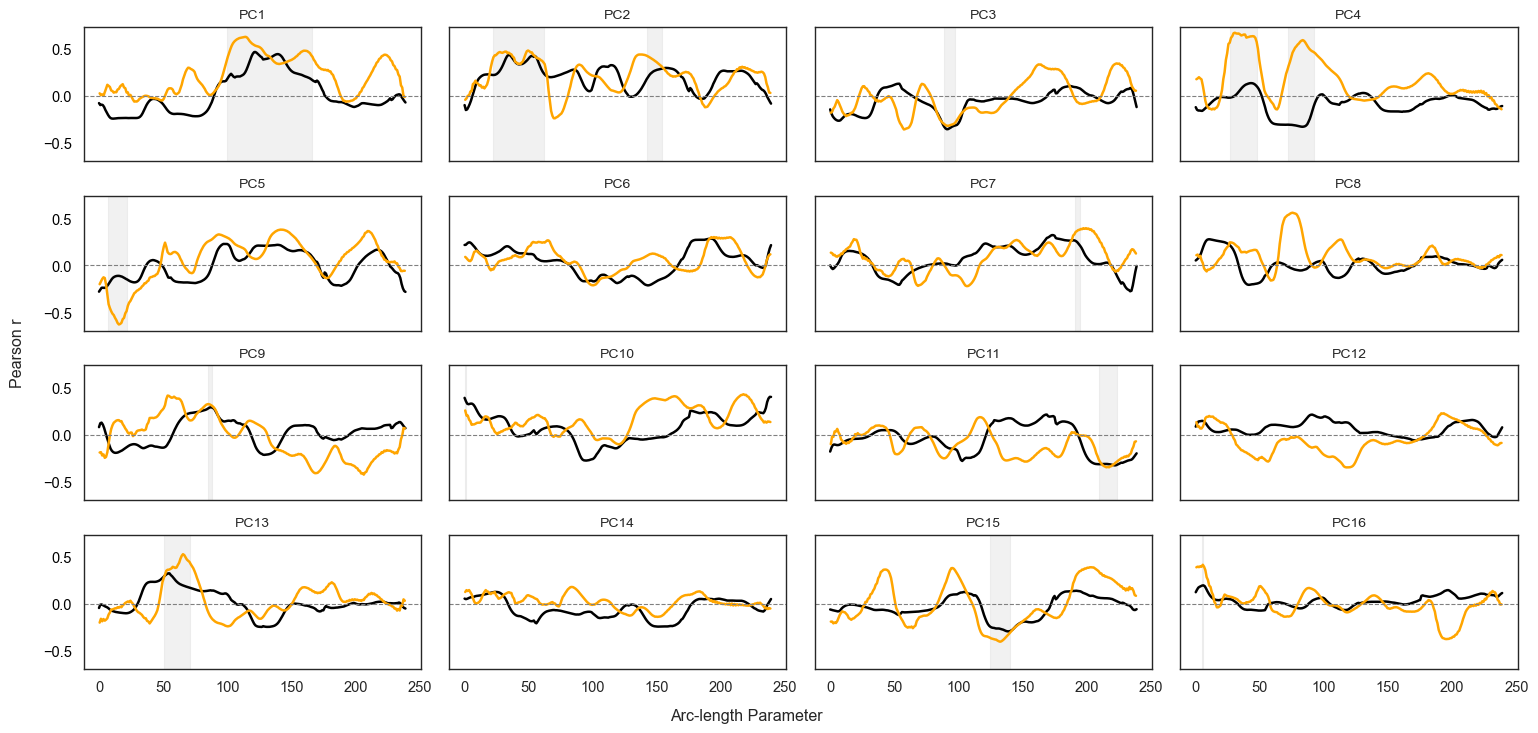

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy.signal import find_peaks
import seaborn as sns

sns.set(style="white", context="paper", font_scale=1.2)

# -------------------------------
# 参数
n_components = tangent_projected_data.shape[1]
n_cols = 4
n_rows = int(np.ceil(n_components / n_cols))
arc_len = f_weighted_unwrapped.shape[0]

# -------------------------------
# 预先计算所有曲线的切线向量并单位化
tangent_devs = []
for i in range(curve_cs.shape[0]):
    diffs = np.diff(curve_cs[i], axis=0)
    norms = np.linalg.norm(diffs, axis=1, keepdims=True)
    diffs /= norms
    tangent_devs.append(diffs)
tangent_devs = np.array(tangent_devs)  # (n_samples, arc_len - 1, 3)

# 均值方向
mean_tangent = np.mean(tangent_devs, axis=0)
mean_tangent /= np.linalg.norm(mean_tangent, axis=1, keepdims=True)

# 对齐切线角度偏离
cos_angles = np.sum(tangent_devs * mean_tangent[None, :, :], axis=2)
angle_deviation = 1 - cos_angles  # shape (n_samples, arc_len - 1)

# -------------------------------
# 画图
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 2 * n_rows), sharex=True, sharey=True)

for pc_index in range(n_components):
    ax = axes.flat[pc_index]
    pc_scores = tangent_projected_data[:, pc_index]
    threshold = np.median(pc_scores)
    high_idx = pc_scores > threshold
    low_idx = pc_scores <= threshold

    # 曲率 vs PC
    curvature_corrs = np.array([
        pearsonr(pc_scores, f_weighted_unwrapped[j, :])[0]
        for j in range(f_weighted_unwrapped.shape[0])
    ])

    # 角度偏离 vs PC
    angle_corrs = np.array([
        pearsonr(pc_scores, angle_deviation[:, j])[0]
        for j in range(angle_deviation.shape[1])
    ])

    # -----------------------------
    # 新增：标注高相关背景
    combined_strength = np.abs(curvature_corrs[:len(angle_corrs)]) + np.abs(angle_corrs)
    threshold_corr = 0.6  # 可调
    high_corr_mask = combined_strength > threshold_corr

    in_block = False
    block_start = 0
    for i, val in enumerate(high_corr_mask):
        if val and not in_block:
            block_start = i
            in_block = True
        elif not val and in_block:
            ax.axvspan(block_start, i, color='lightgray', alpha=0.3)
            in_block = False
    if in_block:
        ax.axvspan(block_start, len(high_corr_mask), color='lightgray', alpha=0.3)

    # -----------------------------
    # 画左轴
    ax.plot(curvature_corrs, color='black', linewidth=1.8, label='Curvature Corr')
    ax.plot(np.arange(len(angle_corrs)) + 0.5, angle_corrs, color='orange', linewidth=1.8, label='Tangent Angle Corr')
    ax.axhline(0, linestyle='--', color='gray', linewidth=0.8)

    ax.set_title(f'PC{pc_index + 1}', fontsize=10)
    ax.tick_params(axis='y', labelcolor='black')
    ax.grid(False)

# 去掉多余子图
for i in range(n_components, n_rows * n_cols):
    fig.delaxes(axes.flat[i])

fig.text(0.5, 0.04, 'Arc-length Parameter', ha='center')
fig.text(0.04, 0.5, 'Pearson r', va='center', rotation='vertical')

fig.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()
